# Problema de negócio

**Análise de vendas de filiais de lojas de supermercado**

Analisando as vendas das lojas e sua dependência da área das lojas e da contagem diária de clientes

**Contexto**

Um supermercado é uma loja de autoatendimento que oferece uma grande variedade de alimentos, bebidas e produtos domésticos, organizados em seções. Esse tipo de loja é maior e tem uma seleção mais ampla do que as mercearias anteriores, mas é menor e mais limitada na variedade de mercadorias do que um hipermercado ou um grande mercado. No uso diário dos EUA, no entanto, "mercearia" é sinônimo de supermercado e não é usado para se referir a outros tipos de lojas que vendem mantimentos.

[https://www.kaggle.com/datasets/surajjha101/stores-area-and-sales-data?datasetId=2133850&sortBy=voteCount](https://www.kaggle.com/datasets/surajjha101/stores-area-and-sales-data?datasetId=2133850&sortBy=voteCount)

**Como o problema é resolvido atualmente ?**

    Os analistas de negócio usam a média das últimas vendas para estimar as próximas nas filiais em destaque.

    Baseline = Média das últimas vendas

    Deve-se calcular o erro que a atual solução traz e o seu custo financeiro

    Alavancas ( aumento de vendas, redução de stockout, redução de custos, aumento de faturamento, previsão de demanda)

# Entendimento dos dados

No conjunto de dados, você obterá dados de diferentes lojas de uma empresa de supermercado de acordo com seus IDs de loja que, para facilitar, foram convertidos em números inteiros positivos.

**ID da loja:** (Índice) ID da loja específica.

**Store_Area:** Área Física da loja em metro quadrado.

**Items_Available:** Número de diferentes itens disponíveis na loja correspondente.

**Daily_Customer_Count:** número de clientes que visitaram as lojas em média ao longo do mês.

**Store_Sales:** Vendas em (US$) que as lojas realizaram.

# Bibliotecas

In [57]:
import pandas as pd
import numpy as np 
import seaborn as sns 
from matplotlib import pyplot as plt 
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RepeatedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import  Pipeline, make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, ElasticNet, Lasso
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from lightgbm import LGBMRegressor 
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.model_selection import FeatureImportances


import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm
import mlflow.catboost

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

import os
import logging
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)

# Separação dos dados

 - Separar treino e teste
 - A amostra de teste será a base de cálculo do ROI 
 - Para calcular o ROI o baseline será a média de vendas por filial simulando a forma como os analistas de negócio estimam as vendas da rede de supermercadossklearn.neural_network

In [2]:
path = r'C:\Users\erico\Documents\projeto-regressao\Supermarket-store-sales-prediction\data\raw\Stores.csv'

data = pd.read_csv(path, sep=';')

In [3]:
data.head()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
0,1,1659,1961,530,66490
1,2,1461,1752,210,39820
2,3,1340,1609,720,54010
3,4,1451,1748,620,53730
4,5,1770,2111,450,46620


In [4]:
train, test = train_test_split(data, test_size=0.20, random_state=42)

In [5]:
train.shape

(716, 5)

In [6]:
test.shape

(180, 5)

In [7]:
# ETL interim
#train.to_csv(r'C:\Users\erico\Documents\projeto-regressao\Supermarket-store-sales-prediction\data\interim\train.csv',index=False)
#test.to_csv(r'C:\Users\erico\Documents\projeto-regressao\Supermarket-store-sales-prediction\data\interim\test.csv',index=False)

# EDA 
 - Na amostra de treino apenas
 - O teste não será visto pois é para simular o ambiente em produção

In [8]:
df_train = pd.read_csv(r'C:\Users\erico\Documents\projeto-regressao\Supermarket-store-sales-prediction\data\interim\train.csv', sep=',')

In [9]:
df_train.head()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
0,737,1098,1309,860,59530
1,383,1454,1737,870,23090
2,707,1495,1793,1020,65300
3,818,1608,1962,770,36280
4,119,1500,1798,860,56710


In [10]:
# Sanit check

def sanit_check(df:pd.DataFrame):

    print(f'Número de linhas: {df.shape[0]} \n')
    print(f'Número de colunas {df.shape[1]} \n')
    print(f'Número de linhas duplicadas: {df.duplicated().sum()}\n')
    print(f'Número de linhas nulas:\n {df.isnull().sum()}')

    return None

In [11]:
sanit_check(df_train)

Número de linhas: 716 

Número de colunas 5 

Número de linhas duplicadas: 0

Número de linhas nulas:
 Store ID                0
Store_Area              0
Items_Available         0
Daily_Customer_Count    0
Store_Sales             0
dtype: int64


Não há dados duplicados ou nulos !

<Axes: >

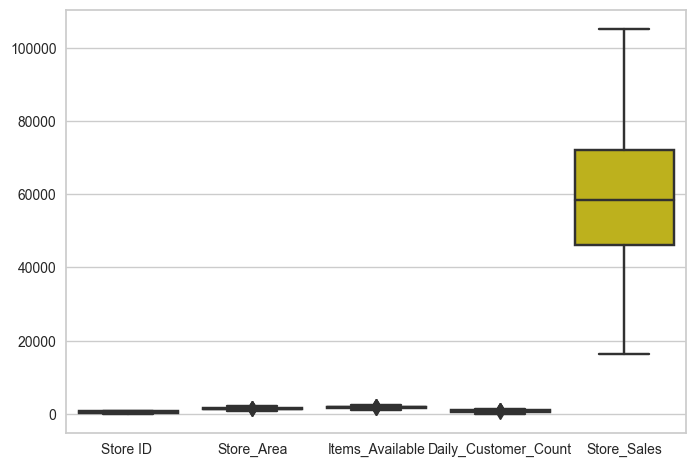

In [12]:
# Check outliers
sns.boxplot(df_train)

Aparentemente não temos outliers nos dados de treino

In [13]:
df_train.describe()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
count,716.000000,716.000000,716.000000,716.000000,716.000000
mean,450.437151,1482.632682,1778.560056,785.237430,59170.377095
std,257.862012,251.766360,301.446876,259.725136,17357.070464
min,1.000000,775.000000,932.000000,70.000000,16370.000000
25%,225.750000,1315.500000,1571.000000,610.000000,46190.000000
50%,456.500000,1472.000000,1763.000000,770.000000,58385.000000
75%,675.500000,1648.250000,1981.250000,950.000000,72127.500000
max,896.000000,2229.000000,2667.000000,1560.000000,105150.000000


Achados da descritiva acima:

    - Store_Area, Items_Available,	Daily_Customer_Count têm um leve desvio padrão considerando a distância entre os valores máximos e minimos destas variáveis
    - Store_Sales tem um desvio padrão maior, acredito que esta target não tenha uma distribuição normal deve-se testar esta hipótese mais tarde
    - A venda máxima diária foi de $ 105.150,00 e a minima de $ 16.370,00

# Hipóteses de negócio

### 1 - Quanto maior a área física da loja maior as vendas !

<Axes: xlabel='Store_Area', ylabel='Store_Sales'>

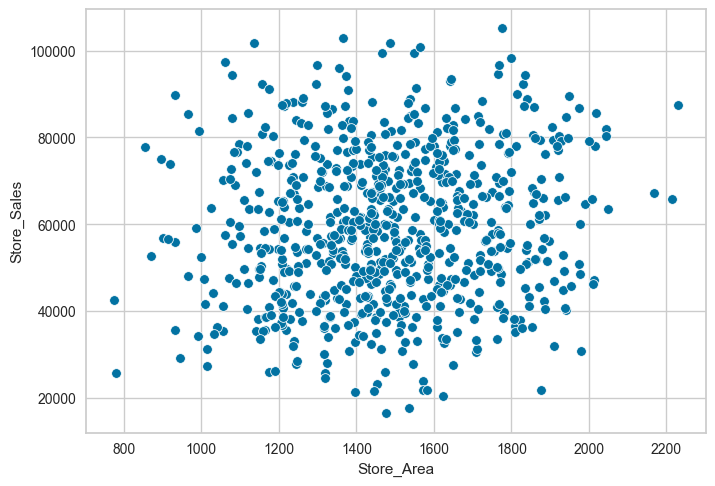

In [14]:
sns.scatterplot(x=df_train['Store_Area'], y=df_train['Store_Sales'])

- Analisando o gráfico aparenta ser falsa esta hipótese, não vejo uma relação linear forte entre os dados

- As maiores vendas se concetram em lojas com 1200 a 1800 metros quadrados

In [15]:
# Testar a H0 de que há uma correlação linear entre a área física da loja e as vendas. 
from scipy.stats import pearsonr

In [16]:
corr, p_value = pearsonr(df_train['Store_Area'], df_train['Store_Sales'])
print('Correlação:', corr)
print('Valor p:', p_value)

Correlação: 0.09928637110096922
Valor p: 0.007845391240498711


O valor p correspondente testa a hipótese nula de que não há correlação linear entre as duas variáveis. Se o valor p for menor que um nível de significância pré-definido (por exemplo, 0,05), isso indica que a hipótese nula pode ser rejeitada em favor da hipótese alternativa de que há uma correlação linear significativa entre as duas variáveis. O valor da correlação indica a direção e a magnitude da relação, ou seja, quanto maior a área física da loja, maior as vendas, mantidas as outras variáveis constantes.

H0 aceita ! Lembrando que correlação não é causalidade

### 2 - Quanto mais itens disponíveis na loja maior as vendas !

<Axes: xlabel='Items_Available', ylabel='Store_Sales'>

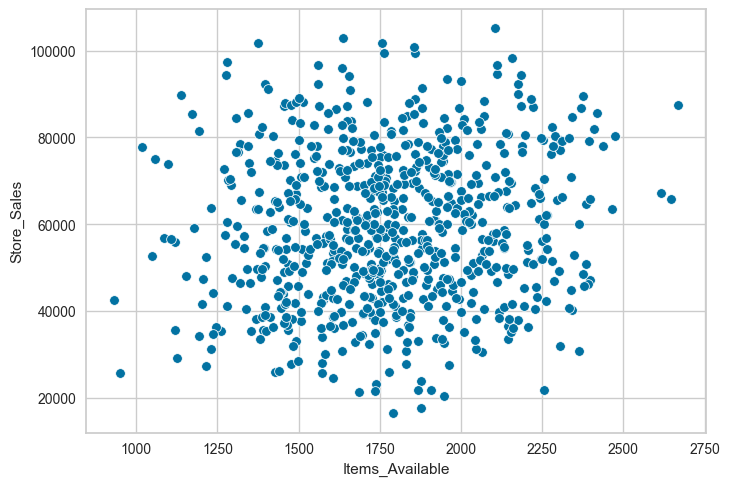

In [17]:
sns.scatterplot(x=df_train['Items_Available'], y=df_train['Store_Sales'])

- Os dados estão bastante dispersos também não há uma forte correlação entre a quantidade de itens para avaliação e o valor de vendas
- Os maiores valores de vendas se concetram na quantidade de itens para avaliação entre 1250 e 2250.

In [18]:
corr, p_value = pearsonr(df_train['Items_Available'], df_train['Store_Sales'])
print('Correlação:', corr)
print('Valor p:', p_value)

Correlação: 0.10009049620048739
Valor p: 0.007355773008398902


H0 aceita ! Hipótese verdadeira.

### 3 - Quanto mais visitas na loja maior as vendas !

<Axes: xlabel='Daily_Customer_Count', ylabel='Store_Sales'>

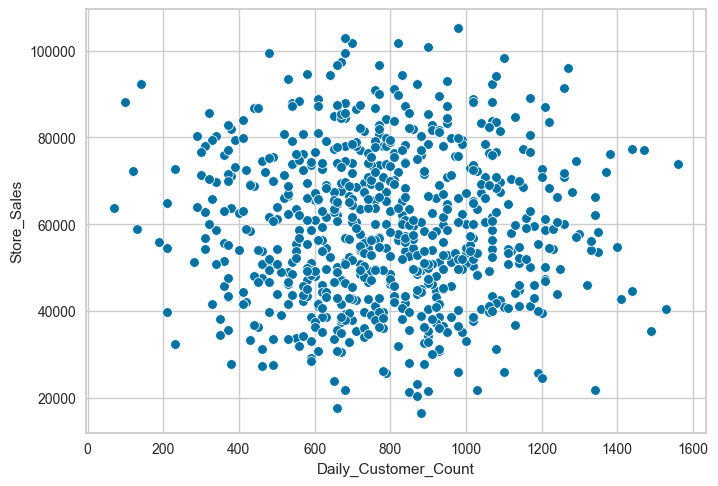

In [19]:
sns.scatterplot(x=df_train['Daily_Customer_Count'], y=df_train['Store_Sales'])

- Pelo gráfico tambem não temos uma forte correlação entre as variáveis
- Os maiores valores de vendas se concetram entre 600 e 1000 visitantes nas lojas

In [20]:
corr, p_value = pearsonr(df_train['Daily_Customer_Count'], df_train['Store_Sales'])
print('Correlação:', corr)
print('Valor p:', p_value)

Correlação: -0.01391553868890451
Valor p: 0.7100999525203255


H0 rejeitada ! Há uma correlação negativa entre as variáveis, quanto maior o número de visitantes menor é o valor de vendas.

    - Deve-se investigar o porquê e a causa, pois há um viés em pensarmos que quanto mais visitantes maiores as chances de compra, porém não é isto que oconteceu.
    - Será que quanto maior o número de visitantes pior é o atendimento ? Ou os clientes não gostam de esperar demais nas filas ? Deve-se investigar no campo !

# Análise Multivariada

In [21]:
# Verificar a correlação entre todas as variáveis 
corr = df_train.corr()

corr.style.background_gradient(cmap= 'coolwarm')

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
Store ID,1.000000,-0.090003,-0.086335,0.012928,0.079532
Store_Area,-0.090003,1.000000,0.998919,-0.050314,0.099286
Items_Available,-0.086335,0.998919,1.000000,-0.051089,0.100090
Daily_Customer_Count,0.012928,-0.050314,-0.051089,1.000000,-0.013916
Store_Sales,0.079532,0.099286,0.100090,-0.013916,1.000000


# Análise bivariada

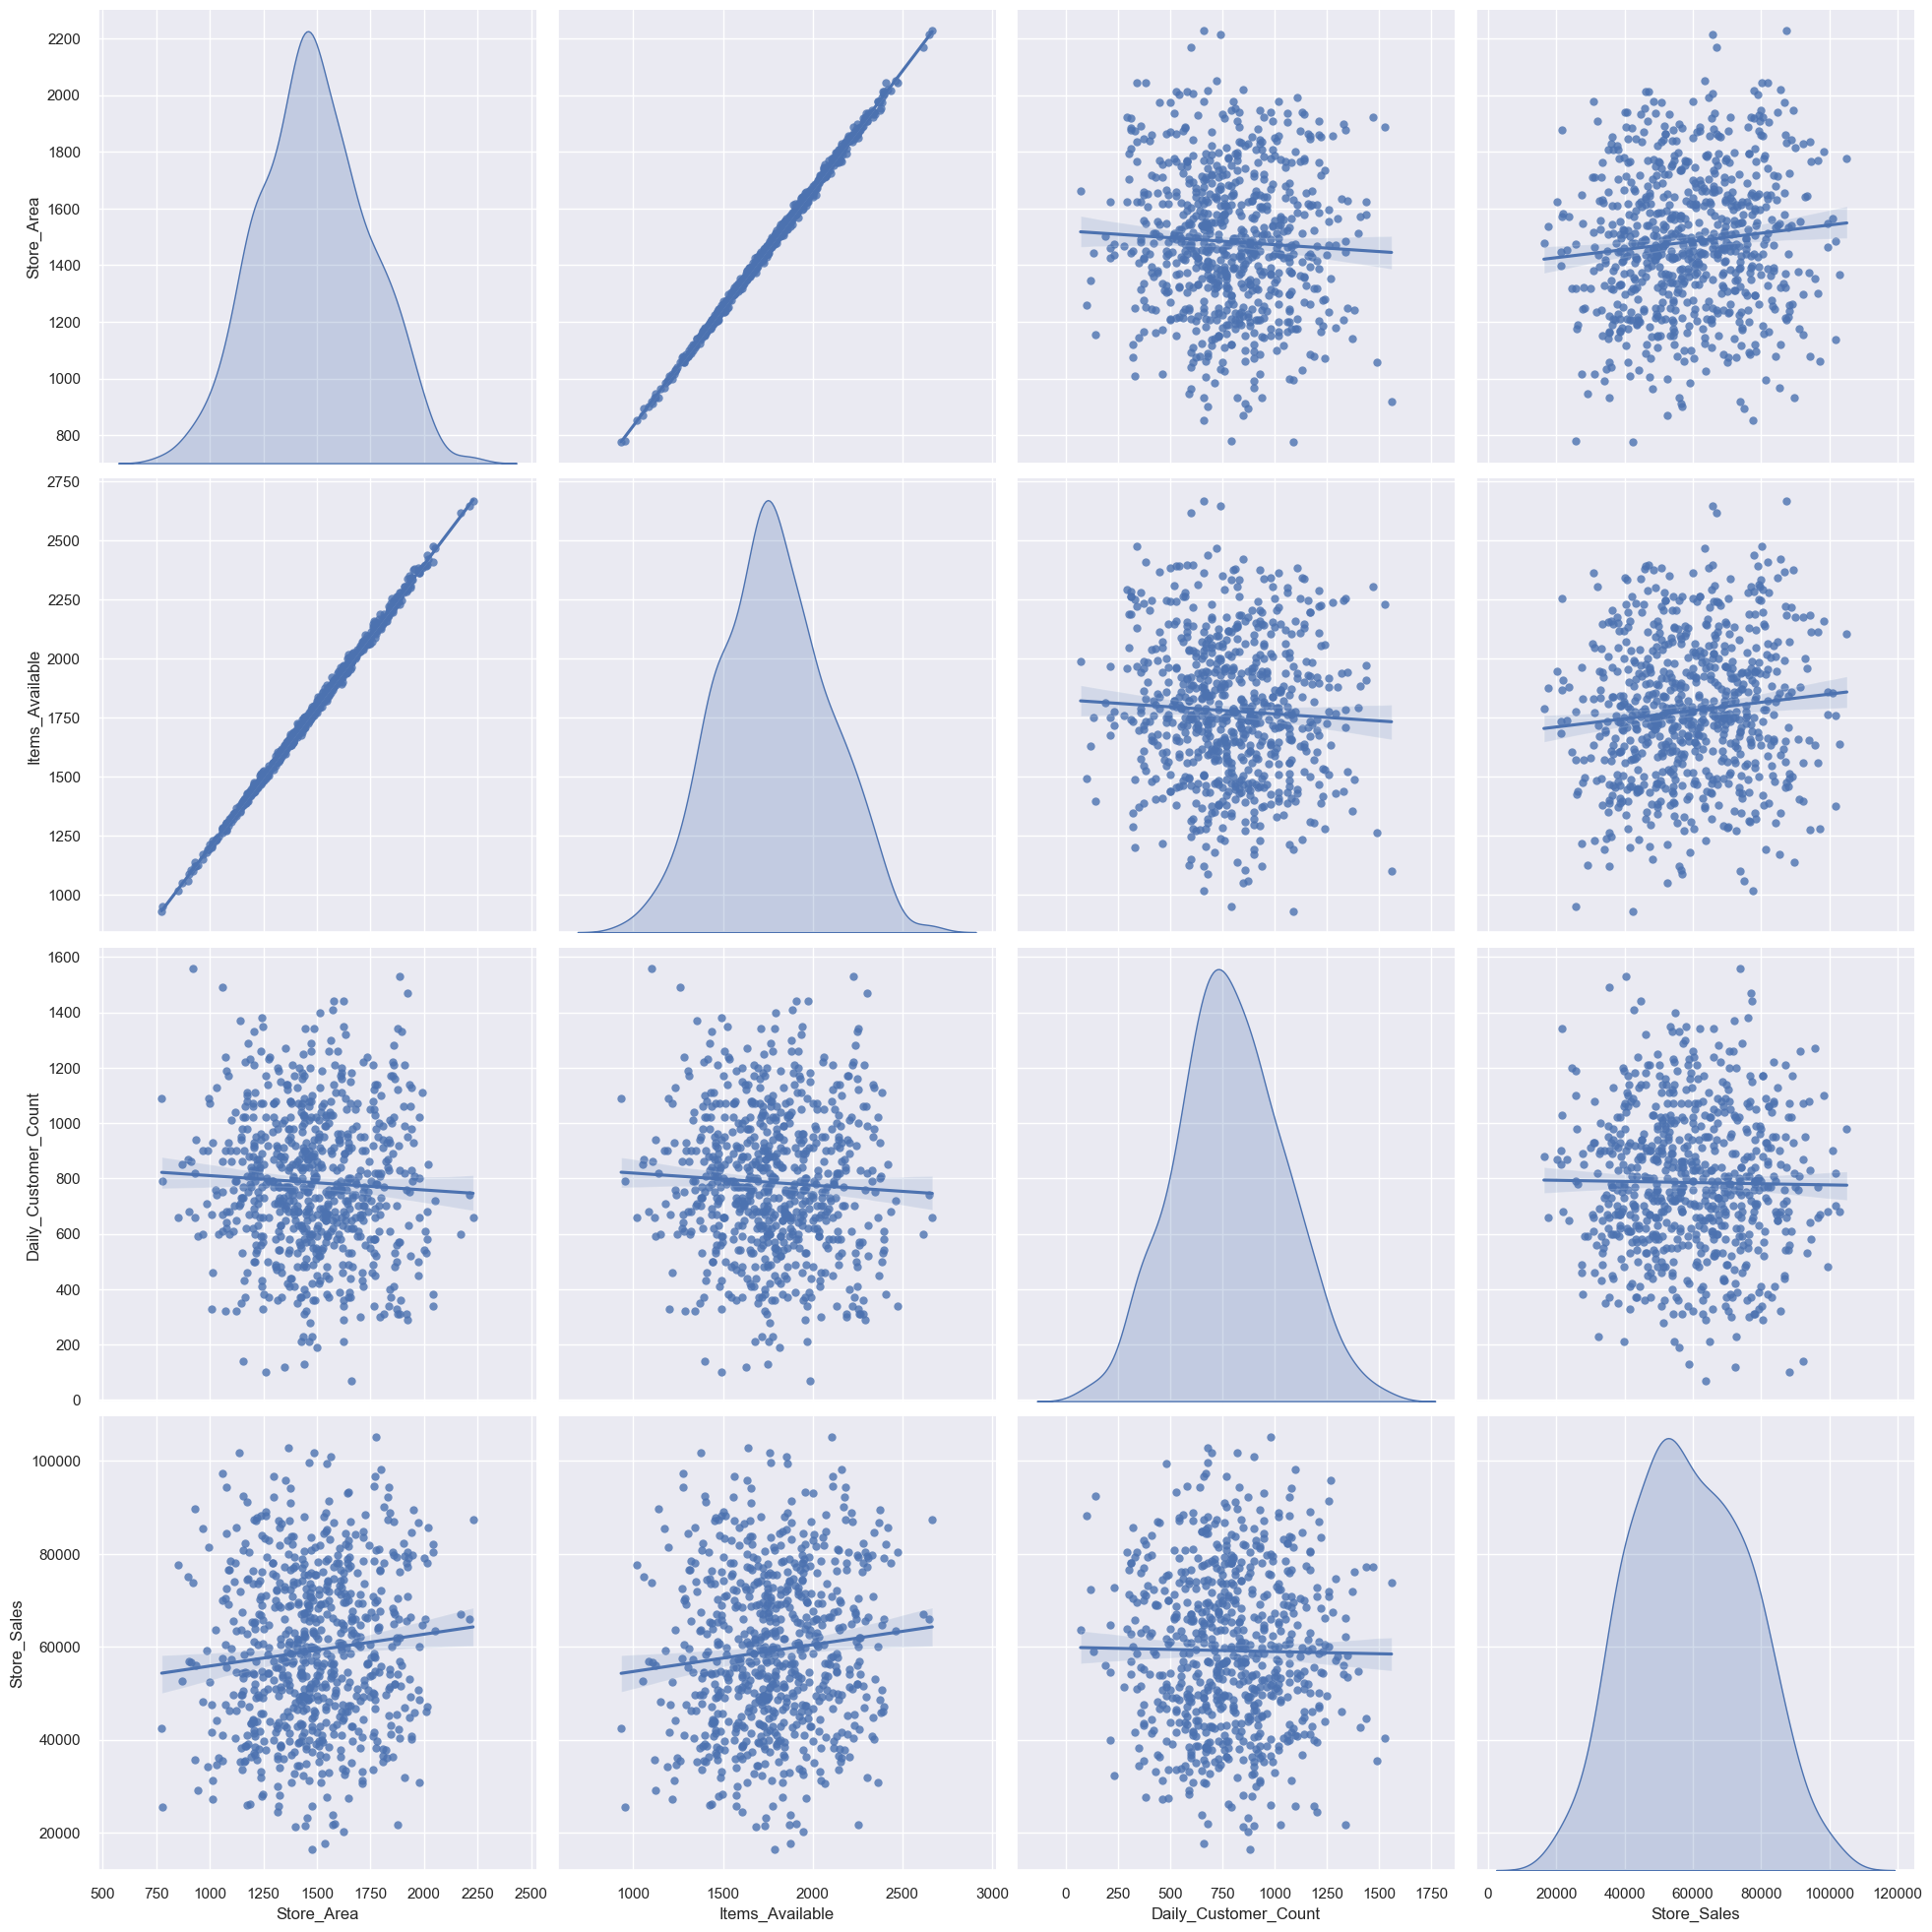

In [22]:
sns.set()
sns.pairplot(df_train.iloc[:,[1,2,3,4]],height = 5 ,kind ='reg',diag_kind='kde')
plt.show()

- A uma forte correlação entre Store_Area e Items_Available
- A correlações positivas fracas entre as variáveis Store_Area e Items_Available com a target Store_Sales

Dito isto será um desafio montar um modelo linear que consiga bons resultados com estas variáveis.

# Análise Univariada

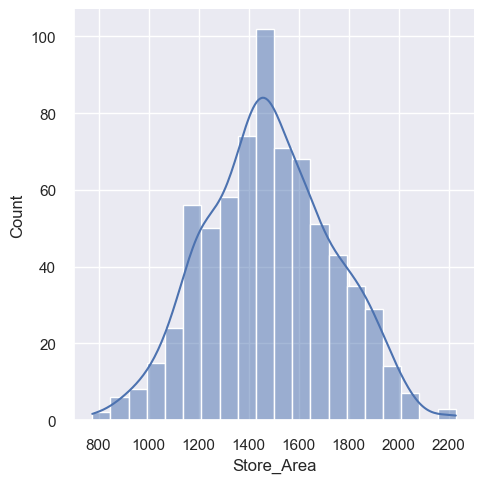

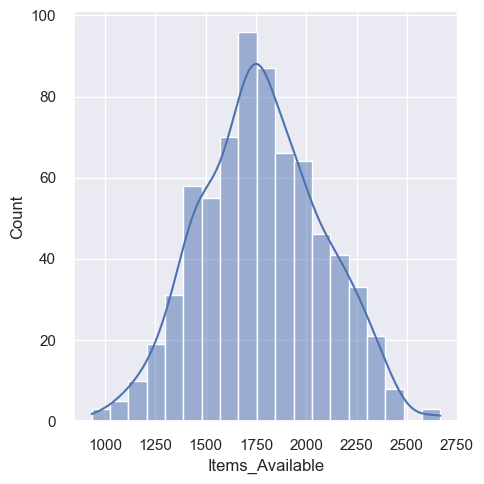

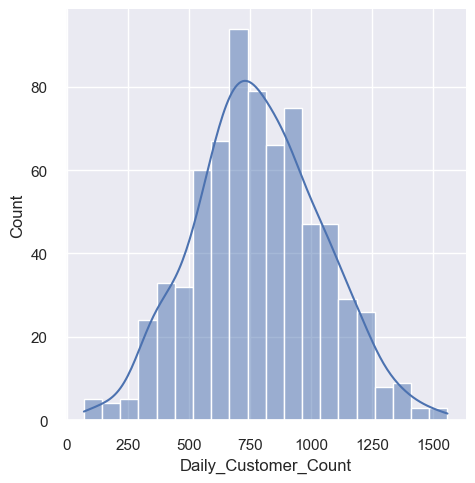

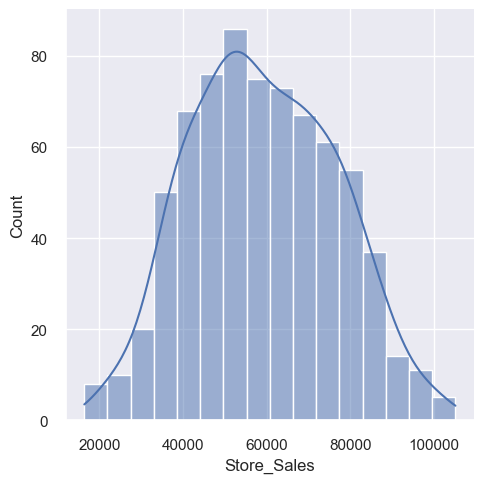

In [23]:
for col in df_train.iloc[:,[1,2,3,4]].columns.to_list():

    sns.displot(df_train[col], kde=True)

- Os gráficos apresentam as variáveis com as distribuições de dados em formato de sino, mas não tenho certeza se elas têm uma distribuição normal, para validar a premissa dos modelos lineares.
- Vou fazer alguns testes de hipóteses nestas variáveis para ter certeza !

In [24]:
from scipy import stats

In [25]:
def test_norm(data: pd.DataFrame):
    for col in data.columns:
        stat, p = stats.shapiro(data[col])
        print(f'Coluna {col}: Estatística de teste = {stat:.3f}, p-valor = {p:.3f}')

        if p > 0.05:
            print(f'Os dados da coluna {col} têm distribuição normal.')
        else:
            print(f'Os dados da coluna {col} não têm distribuição normal.')

In [26]:
test_norm(df_train.iloc[:,[1,2,3,4]])

Coluna Store_Area: Estatística de teste = 0.997, p-valor = 0.139
Os dados da coluna Store_Area têm distribuição normal.
Coluna Items_Available: Estatística de teste = 0.997, p-valor = 0.157
Os dados da coluna Items_Available têm distribuição normal.
Coluna Daily_Customer_Count: Estatística de teste = 0.998, p-valor = 0.390
Os dados da coluna Daily_Customer_Count têm distribuição normal.
Coluna Store_Sales: Estatística de teste = 0.992, p-valor = 0.001
Os dados da coluna Store_Sales não têm distribuição normal.


Por não termos uma distribuiçõ normal na target talvez precisaremos alterar sua natureza para facilitar a previsão dos algoritmos ou usar modelos robustos para estes tipos de dados 

# Baseline de média dos analistas nos dados de teste

In [27]:
# teste
df_teste = pd.read_csv(r'C:\Users\erico\Documents\projeto-regressao\Supermarket-store-sales-prediction\data\interim\test.csv', sep=',')

In [28]:
# Modelo  de média

# Calcular média de vendas 
mean_sales = np.mean(df_teste['Store_Sales'])

In [29]:
# Prever a média de vendas para cada loja
predictions = np.full(len(df_teste), mean_sales)

In [30]:
# Calcular erro baseline MAE RMSE MAPE

R2 = r2_score(df_teste['Store_Sales'], predictions) 
RMSE = np.sqrt(mean_squared_error(df_teste['Store_Sales'], predictions))
MAPE = mean_absolute_percentage_error(df_teste['Store_Sales'], predictions)

In [31]:
print(f"R2: {R2:.2f}")
print(f"RMSE: {RMSE:.2f}")
print(f"MAPE: {MAPE:.2%}")

R2: 0.00
RMSE: 16493.87
MAPE: 25.74%


    - O modelo de média tem um erro em torno de 25,74% 
    - Nosso objetivo será reduzir este erro

# Feature Engineering

### Mapa Mental de variáveis 

- 

# Modelagem - Machine Learning

## Treino/Validação

In [32]:
# Separar variáveis independentes e dependente
X = df_train.drop(['Store_Sales'], axis=1)
y = df_train['Store_Sales']

In [33]:
X.head()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count
0,737,1098,1309,860
1,383,1454,1737,870
2,707,1495,1793,1020
3,818,1608,1962,770
4,119,1500,1798,860


In [34]:
y

0      59530
1      23090
2      65300
3      36280
4      56710
       ...  
711    69310
712    26220
713    48950
714    52060
715    89080
Name: Store_Sales, Length: 716, dtype: int64

In [64]:
# definir função para treinar e validar os modelos e registrar os resultados dos experimentos

def train_validation_eval(model_name, model, X, y, gridsearch=False, params_grid=None, run_name=None, experiment_name=None, path_save_fig=None):
    
    
    logging.info("Função train_validation_eval iniciada")
    
    # listas de métricas para append futuro
    r2 = []
    rmse = []
    mape = []
    
    # inicializar variável best_model, best_param e default_params
    best_model = None
    best_param = None
    default_params = None
    
    logging.info("Iniciando loop de validação cruzada")
    # Cross validation
    n_splits = 5
    RdKFOLD = RepeatedKFold(n_splits=n_splits, n_repeats=2, random_state=42)
    fold = 0 
    
    # Split treino e validação hold out
    for train_ix, val_ix in RdKFOLD.split(X):
        
        fold+=1
        
        X_train, X_valid = X.iloc[train_ix, :], X.iloc[val_ix, :]
        y_train, y_valid = y.iloc[train_ix], y.iloc[val_ix]
        
        if gridsearch == False:
            logging.info(f"Treinando {model_name} com parâmetros padrão, fold {fold}")
            # Treino modelo default
            model.fit(X_train, y_train)
            logging.info(f"Prevendo conjunto de validação com {model_name} padrão, fold {fold}")
            # pegar parâtros default
            default_params = model.get_params()
            # Prever na validaçã
            yhat = model.predict(X_valid)
            
        else:
            logging.info(f"Treinando {model_name} com parâmetros otimizados pelo GridSearch, fold {fold}")
            # Definir espaço de gridsearch
            search = GridSearchCV(model, params_grid, scoring='neg_root_mean_squared_error', cv=RdKFOLD, n_jobs=-1)
            # Ajustar modelo
            search_result = search.fit(X_train, y_train) 
            # melhor parâmetro
            best_param = search_result.best_params_
            # melhor modelo
            best_model = search_result.best_estimator_
            logging.info(f"Prevendo conjunto de validação com {model_name} otimizado, fold {fold}")
            # Prever na validação com melhor modelo
            yhat = best_model.predict(X_valid)
        
        logging.info("Avaliando resultados nos dados de validação")
        #Avaliação numerica
        # R2
        R2 = r2_score(y_valid, yhat)
        r2.append(R2)
        # RMSE
        RMSE = np.sqrt(mean_squared_error(y_valid, yhat))
        rmse.append(RMSE)
        # MAPE
        MAPE = mean_absolute_percentage_error(y_valid, yhat)
        mape.append(MAPE)
        
    # Erro de previsão com a reta da regressão
    p = np.polyfit(y_valid, yhat, 1)
    plt.scatter(y_valid, yhat, alpha=0.5)
    plt.plot(y_valid, np.polyval(p, y_valid), color='red')
    plt.xlabel('Valor Real')
    plt.ylabel('Previsão')
    plt.title(f'Reta da Regressão para o modelo {model_name}')
    plt.savefig(os.path.join(path_save_fig,f"{model_name}_regression_error.jpg"),bbox_inches='tight',transparent=False, format='JPG', facecolor='w') 
    plt.show()
    
    # Resíduos dos erros
    residuals = y_valid - yhat
    plt.hist(residuals, bins=25)
    plt.xlabel('Resíduo')
    plt.ylabel('Frequência')
    plt.title(f'Histograma de Erros Resíduais para o modelo {model_name}')
    plt.savefig(os.path.join(path_save_fig,f"{model_name}_residuals.jpg"),bbox_inches='tight',transparent=False, format='JPG', facecolor='w') 
    plt.show()

    # Avaliação na validação
    print(f"Modelo:  {model_name}")
    print(f"R2 CV:   {np.mean(r2):.2f}")
    print(f"RMSE CV: {np.mean(rmse):.2f}")
    print(f"MAPE CV: {np.mean(mape)*100:.2f}%")
    
    if gridsearch == True:
        # Imprimir melhor parâmetro e modelo após o loop de validação cruzada
        print(f"Melhores parâmetros: {best_param}")
        print(f"Melhor modelo: {best_model}")
    
    logging.info("Rastreamento de resultados dos experimentos com MLFLOW iniciado")
    
    mlflow.set_experiment(experiment_name)
    mlflow.set_tracking_uri('http://127.0.0.1:5000')
    
    with mlflow.start_run(run_name=run_name):
        
        if best_param is not None:  
            mlflow.log_params(best_param)
            
        if default_params is not None:
            mlflow.log_params(default_params)
            
        mlflow.log_metrics({'R2 CV': np.mean(r2),
                            'RMSE CV': np.mean(rmse),
                            'MAPE CV': np.mean(mape)
                           })
        
        try:
            mlflow.log_artifact(os.path.join(path_save_fig,f"{model_name}_residuals.jpg"))
            mlflow.log_artifact(os.path.join(path_save_fig,f"{model_name}_regression_error.jpg"))
        except:
            pass
        
        for framework in [mlflow.sklearn, mlflow.xgboost, mlflow.lightgbm, mlflow.catboost]:
            try:
                framework.log_model(model, model_name)
                break
            except Exception:
                pass
        
    mlflow.end_run()
        
    return logging.info('Ciclo de vida dos modelos rastreado com sucesso!')


### Algoritmos com parâmetros padrão

In [65]:
path_save_fig = r'C:\Users\erico\Documents\projeto-regressao\Supermarket-store-sales-prediction\reports\figures'

2023-04-17 22:05:54,234 - Função train_validation_eval iniciada
2023-04-17 22:05:54,236 - Iniciando loop de validação cruzada
2023-04-17 22:05:54,240 - Treinando LinearRegression com parâmetros padrão, fold 1
2023-04-17 22:05:54,245 - Prevendo conjunto de validação com LinearRegression padrão, fold 1
2023-04-17 22:05:54,247 - Avaliando resultados nos dados de validação
2023-04-17 22:05:54,251 - Treinando LinearRegression com parâmetros padrão, fold 2
2023-04-17 22:05:54,255 - Prevendo conjunto de validação com LinearRegression padrão, fold 2
2023-04-17 22:05:54,258 - Avaliando resultados nos dados de validação
2023-04-17 22:05:54,262 - Treinando LinearRegression com parâmetros padrão, fold 3
2023-04-17 22:05:54,267 - Prevendo conjunto de validação com LinearRegression padrão, fold 3
2023-04-17 22:05:54,269 - Avaliando resultados nos dados de validação
2023-04-17 22:05:54,272 - Treinando LinearRegression com parâmetros padrão, fold 4
2023-04-17 22:05:54,277 - Prevendo conjunto de valida

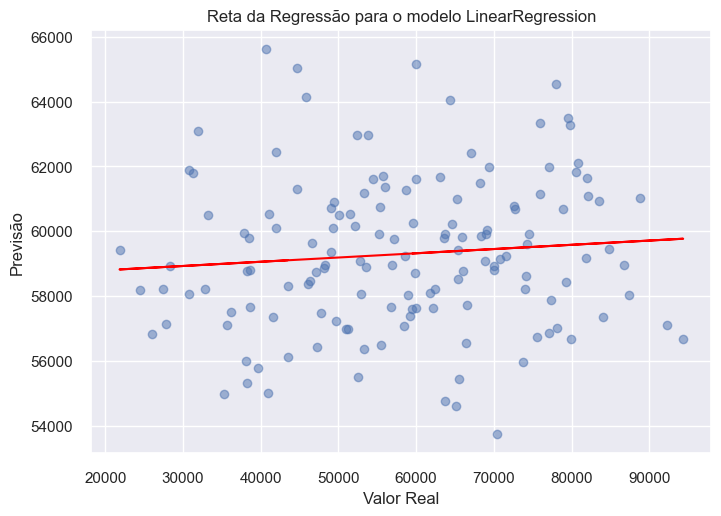

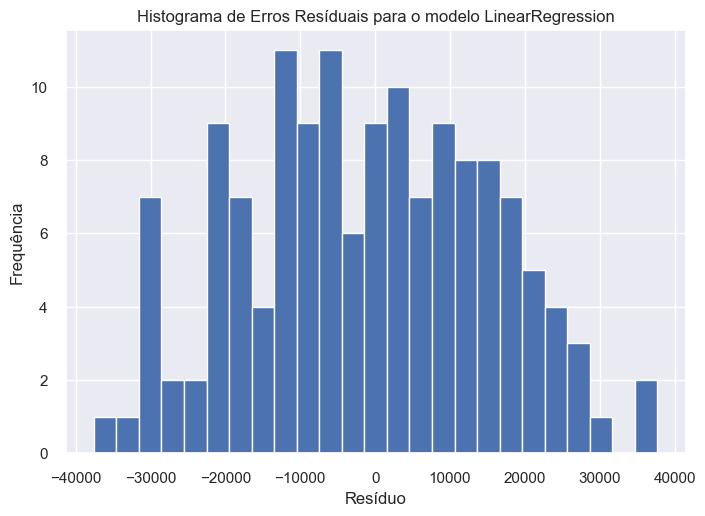

2023-04-17 22:05:55,100 - Rastreamento de resultados dos experimentos com MLFLOW iniciado
2023/04/17 22:05:55 INFO mlflow.tracking.fluent: Experiment with name 'Modelos com parâmetros padrão - treino e validação' does not exist. Creating a new experiment.


Modelo:  LinearRegression
R2 CV:   -0.00
RMSE CV: 17312.87
MAPE CV: 28.60%


2023-04-17 22:05:58,930 - Ciclo de vida dos modelos rastreado com sucesso!
2023-04-17 22:05:58,930 - Função train_validation_eval iniciada
2023-04-17 22:05:58,931 - Iniciando loop de validação cruzada
2023-04-17 22:05:58,934 - Treinando RandomForestRegressor com parâmetros padrão, fold 1
2023-04-17 22:05:59,196 - Prevendo conjunto de validação com RandomForestRegressor padrão, fold 1
2023-04-17 22:05:59,206 - Avaliando resultados nos dados de validação
2023-04-17 22:05:59,209 - Treinando RandomForestRegressor com parâmetros padrão, fold 2
2023-04-17 22:05:59,475 - Prevendo conjunto de validação com RandomForestRegressor padrão, fold 2
2023-04-17 22:05:59,486 - Avaliando resultados nos dados de validação
2023-04-17 22:05:59,491 - Treinando RandomForestRegressor com parâmetros padrão, fold 3
2023-04-17 22:05:59,750 - Prevendo conjunto de validação com RandomForestRegressor padrão, fold 3
2023-04-17 22:05:59,762 - Avaliando resultados nos dados de validação
2023-04-17 22:05:59,767 - Trein

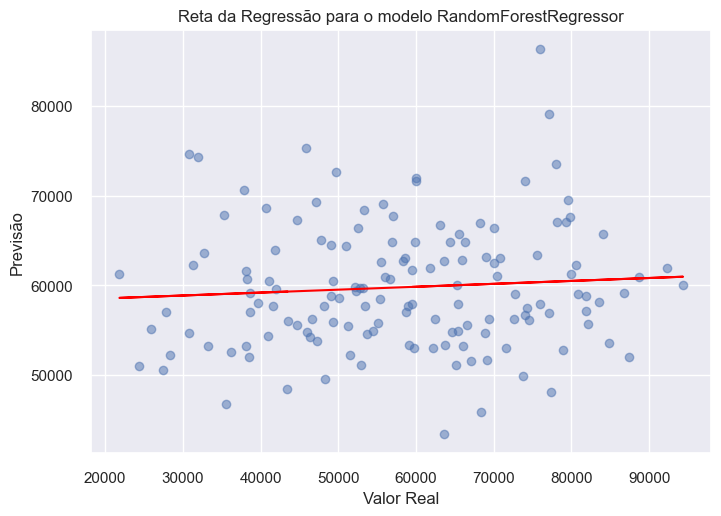

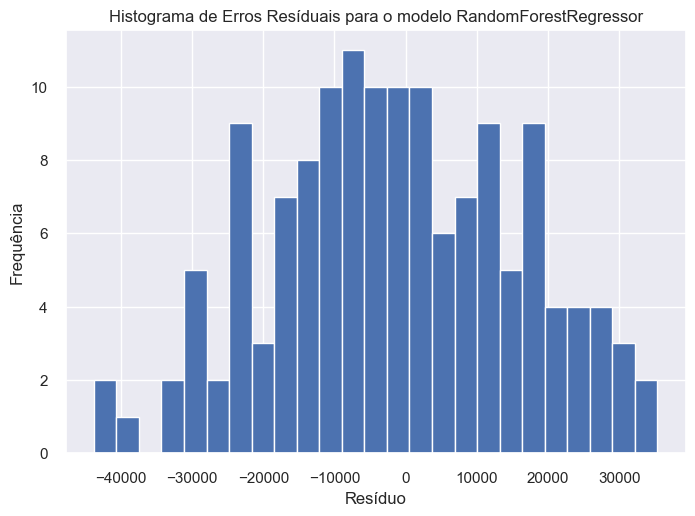

2023-04-17 22:06:02,437 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  RandomForestRegressor
R2 CV:   -0.08
RMSE CV: 17985.76
MAPE CV: 29.40%


2023-04-17 22:06:06,214 - Ciclo de vida dos modelos rastreado com sucesso!
2023-04-17 22:06:06,215 - Função train_validation_eval iniciada
2023-04-17 22:06:06,215 - Iniciando loop de validação cruzada
2023-04-17 22:06:06,218 - Treinando Ridge com parâmetros padrão, fold 1
2023-04-17 22:06:06,222 - Prevendo conjunto de validação com Ridge padrão, fold 1
2023-04-17 22:06:06,225 - Avaliando resultados nos dados de validação
2023-04-17 22:06:06,229 - Treinando Ridge com parâmetros padrão, fold 2
2023-04-17 22:06:06,232 - Prevendo conjunto de validação com Ridge padrão, fold 2
2023-04-17 22:06:06,235 - Avaliando resultados nos dados de validação
2023-04-17 22:06:06,239 - Treinando Ridge com parâmetros padrão, fold 3
2023-04-17 22:06:06,242 - Prevendo conjunto de validação com Ridge padrão, fold 3
2023-04-17 22:06:06,245 - Avaliando resultados nos dados de validação
2023-04-17 22:06:06,249 - Treinando Ridge com parâmetros padrão, fold 4
2023-04-17 22:06:06,252 - Prevendo conjunto de validaçã

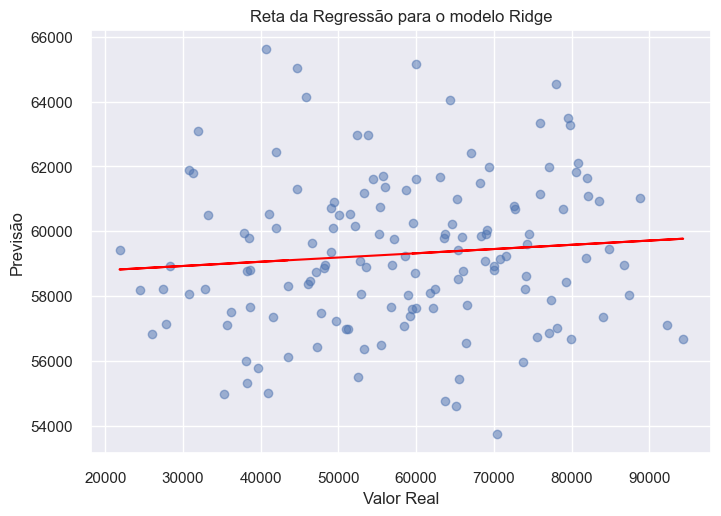

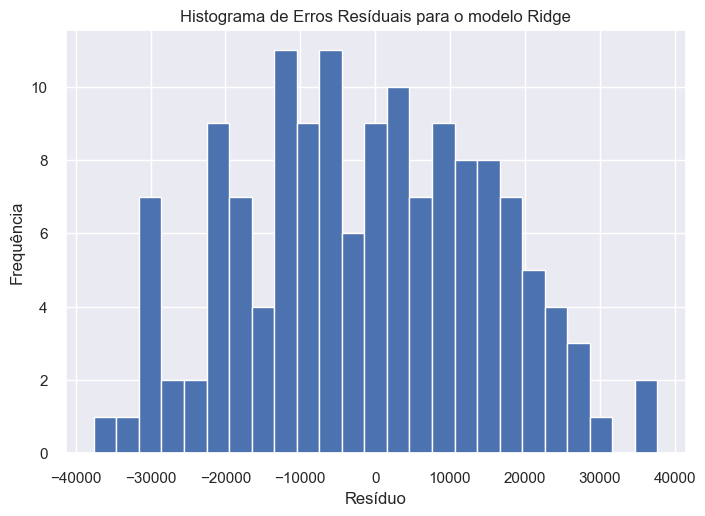

2023-04-17 22:06:07,080 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  Ridge
R2 CV:   -0.00
RMSE CV: 17312.87
MAPE CV: 28.60%


2023-04-17 22:06:10,573 - Ciclo de vida dos modelos rastreado com sucesso!
2023-04-17 22:06:10,573 - Função train_validation_eval iniciada
2023-04-17 22:06:10,574 - Iniciando loop de validação cruzada
2023-04-17 22:06:10,577 - Treinando Lasso com parâmetros padrão, fold 1
2023-04-17 22:06:10,583 - Prevendo conjunto de validação com Lasso padrão, fold 1
2023-04-17 22:06:10,585 - Avaliando resultados nos dados de validação
2023-04-17 22:06:10,589 - Treinando Lasso com parâmetros padrão, fold 2
2023-04-17 22:06:10,592 - Prevendo conjunto de validação com Lasso padrão, fold 2
2023-04-17 22:06:10,595 - Avaliando resultados nos dados de validação
2023-04-17 22:06:10,598 - Treinando Lasso com parâmetros padrão, fold 3
2023-04-17 22:06:10,602 - Prevendo conjunto de validação com Lasso padrão, fold 3
2023-04-17 22:06:10,605 - Avaliando resultados nos dados de validação
2023-04-17 22:06:10,609 - Treinando Lasso com parâmetros padrão, fold 4
2023-04-17 22:06:10,614 - Prevendo conjunto de validaçã

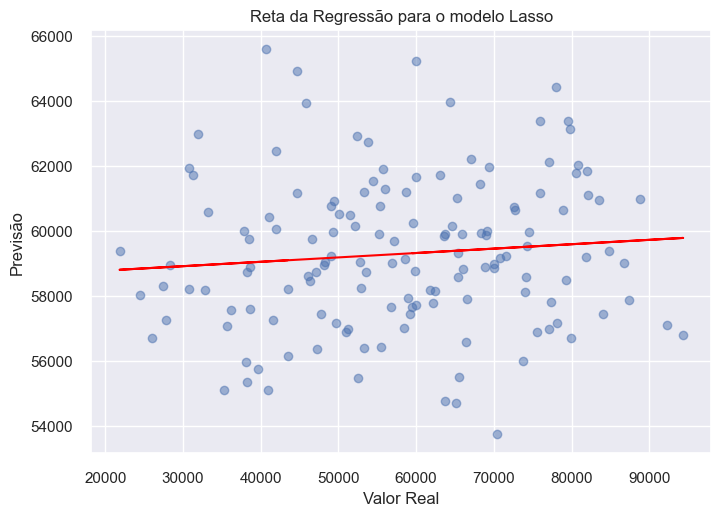

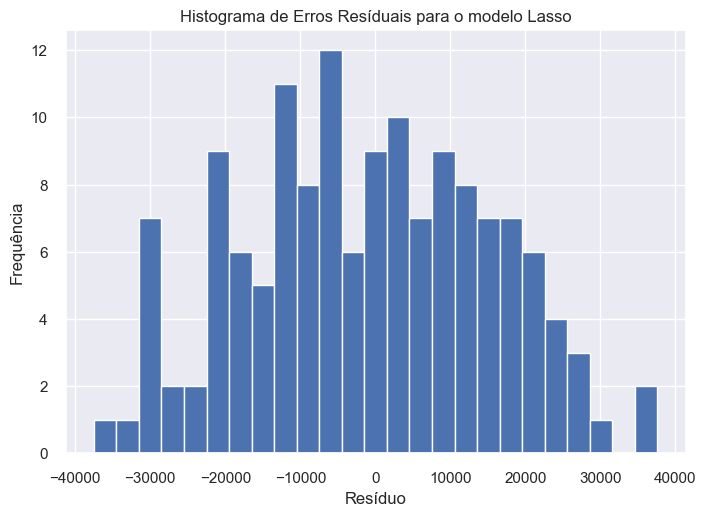

2023-04-17 22:06:11,515 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  Lasso
R2 CV:   -0.00
RMSE CV: 17306.07
MAPE CV: 28.59%


2023-04-17 22:06:15,244 - Ciclo de vida dos modelos rastreado com sucesso!
2023-04-17 22:06:15,244 - Função train_validation_eval iniciada
2023-04-17 22:06:15,245 - Iniciando loop de validação cruzada
2023-04-17 22:06:15,247 - Treinando ElasticNet com parâmetros padrão, fold 1
2023-04-17 22:06:15,252 - Prevendo conjunto de validação com ElasticNet padrão, fold 1
2023-04-17 22:06:15,255 - Avaliando resultados nos dados de validação
2023-04-17 22:06:15,257 - Treinando ElasticNet com parâmetros padrão, fold 2
2023-04-17 22:06:15,263 - Prevendo conjunto de validação com ElasticNet padrão, fold 2
2023-04-17 22:06:15,265 - Avaliando resultados nos dados de validação
2023-04-17 22:06:15,268 - Treinando ElasticNet com parâmetros padrão, fold 3
2023-04-17 22:06:15,271 - Prevendo conjunto de validação com ElasticNet padrão, fold 3
2023-04-17 22:06:15,274 - Avaliando resultados nos dados de validação
2023-04-17 22:06:15,280 - Treinando ElasticNet com parâmetros padrão, fold 4
2023-04-17 22:06:15,

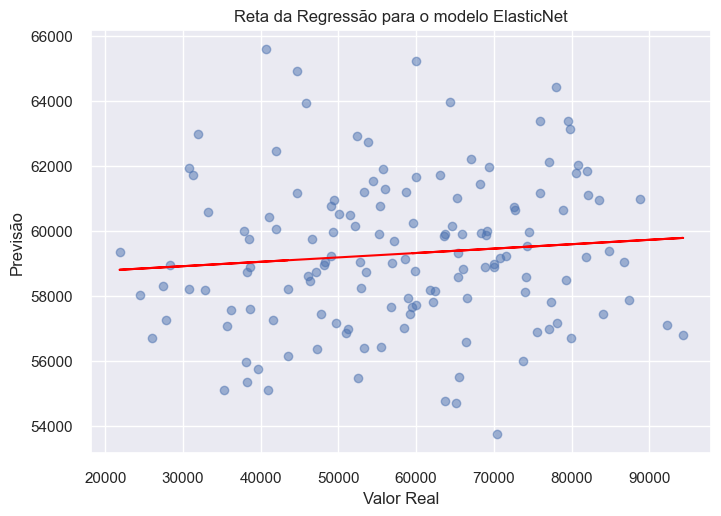

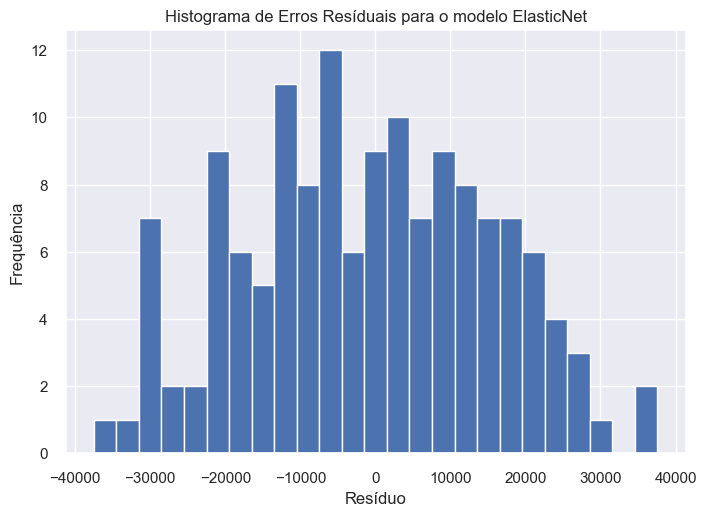

2023-04-17 22:06:16,117 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  ElasticNet
R2 CV:   -0.00
RMSE CV: 17305.86
MAPE CV: 28.59%


2023-04-17 22:06:19,645 - Ciclo de vida dos modelos rastreado com sucesso!
2023-04-17 22:06:19,645 - Função train_validation_eval iniciada
2023-04-17 22:06:19,645 - Iniciando loop de validação cruzada
2023-04-17 22:06:19,654 - Treinando SVR com parâmetros padrão, fold 1
2023-04-17 22:06:19,667 - Prevendo conjunto de validação com SVR padrão, fold 1
2023-04-17 22:06:19,676 - Avaliando resultados nos dados de validação
2023-04-17 22:06:19,679 - Treinando SVR com parâmetros padrão, fold 2
2023-04-17 22:06:19,690 - Prevendo conjunto de validação com SVR padrão, fold 2
2023-04-17 22:06:19,699 - Avaliando resultados nos dados de validação
2023-04-17 22:06:19,701 - Treinando SVR com parâmetros padrão, fold 3
2023-04-17 22:06:19,713 - Prevendo conjunto de validação com SVR padrão, fold 3
2023-04-17 22:06:19,723 - Avaliando resultados nos dados de validação
2023-04-17 22:06:19,726 - Treinando SVR com parâmetros padrão, fold 4
2023-04-17 22:06:19,738 - Prevendo conjunto de validação com SVR padr

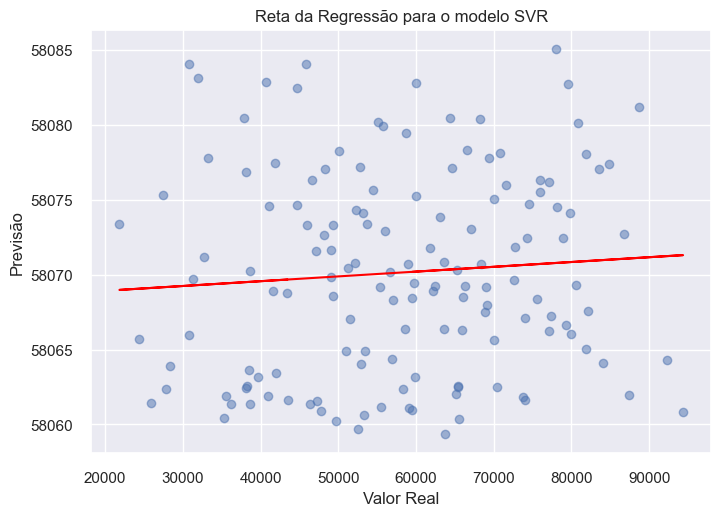

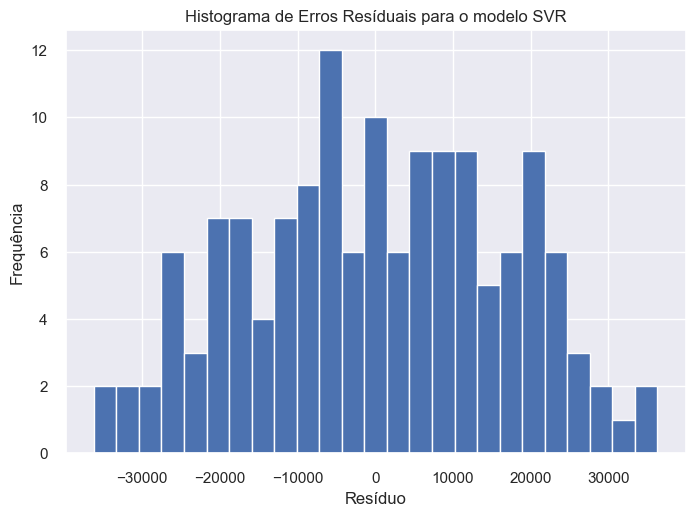

2023-04-17 22:06:20,617 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  SVR
R2 CV:   -0.01
RMSE CV: 17391.48
MAPE CV: 28.28%


2023-04-17 22:06:24,210 - Ciclo de vida dos modelos rastreado com sucesso!
2023-04-17 22:06:24,211 - Função train_validation_eval iniciada
2023-04-17 22:06:24,212 - Iniciando loop de validação cruzada
2023-04-17 22:06:24,216 - Treinando MLPRegressor com parâmetros padrão, fold 1
2023-04-17 22:06:24,730 - Prevendo conjunto de validação com MLPRegressor padrão, fold 1
2023-04-17 22:06:24,733 - Avaliando resultados nos dados de validação
2023-04-17 22:06:24,737 - Treinando MLPRegressor com parâmetros padrão, fold 2
2023-04-17 22:06:25,296 - Prevendo conjunto de validação com MLPRegressor padrão, fold 2
2023-04-17 22:06:25,298 - Avaliando resultados nos dados de validação
2023-04-17 22:06:25,302 - Treinando MLPRegressor com parâmetros padrão, fold 3
2023-04-17 22:06:25,838 - Prevendo conjunto de validação com MLPRegressor padrão, fold 3
2023-04-17 22:06:25,841 - Avaliando resultados nos dados de validação
2023-04-17 22:06:25,843 - Treinando MLPRegressor com parâmetros padrão, fold 4
2023-0

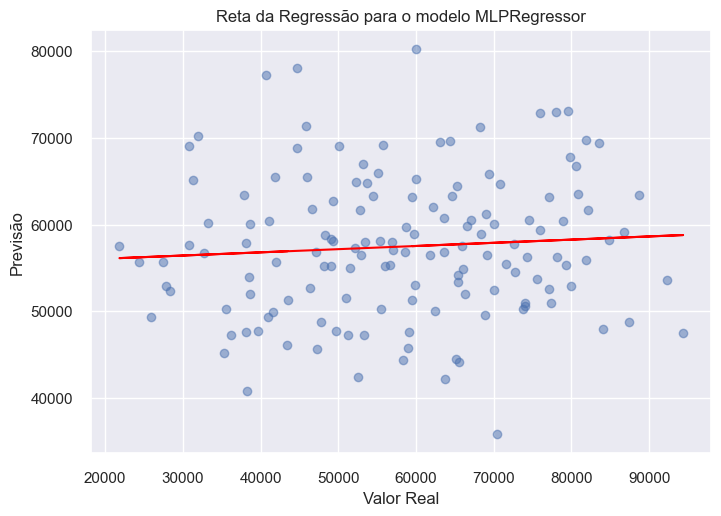

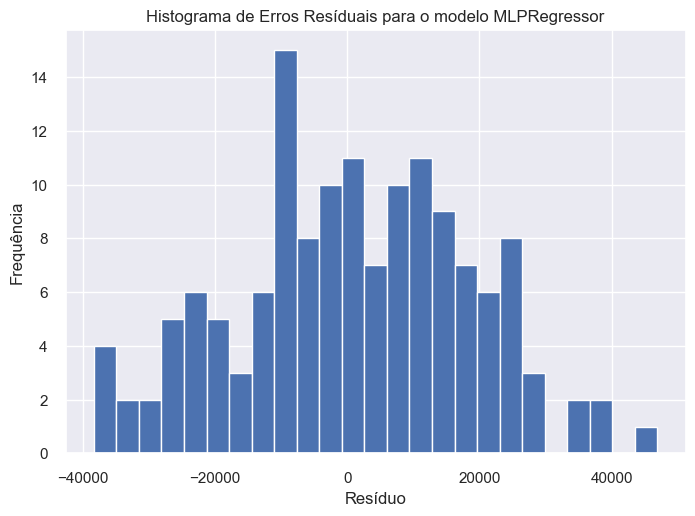

2023-04-17 22:06:30,255 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  MLPRegressor
R2 CV:   -0.13
RMSE CV: 18369.32
MAPE CV: 28.90%


2023-04-17 22:06:33,888 - Ciclo de vida dos modelos rastreado com sucesso!
2023-04-17 22:06:33,889 - Função train_validation_eval iniciada
2023-04-17 22:06:33,889 - Iniciando loop de validação cruzada
2023-04-17 22:06:33,893 - Treinando XGBRegressor com parâmetros padrão, fold 1
2023-04-17 22:06:34,024 - Prevendo conjunto de validação com XGBRegressor padrão, fold 1
2023-04-17 22:06:34,030 - Avaliando resultados nos dados de validação
2023-04-17 22:06:34,033 - Treinando XGBRegressor com parâmetros padrão, fold 2
2023-04-17 22:06:34,140 - Prevendo conjunto de validação com XGBRegressor padrão, fold 2
2023-04-17 22:06:34,152 - Avaliando resultados nos dados de validação
2023-04-17 22:06:34,158 - Treinando XGBRegressor com parâmetros padrão, fold 3
2023-04-17 22:06:34,264 - Prevendo conjunto de validação com XGBRegressor padrão, fold 3
2023-04-17 22:06:34,268 - Avaliando resultados nos dados de validação
2023-04-17 22:06:34,278 - Treinando XGBRegressor com parâmetros padrão, fold 4
2023-0

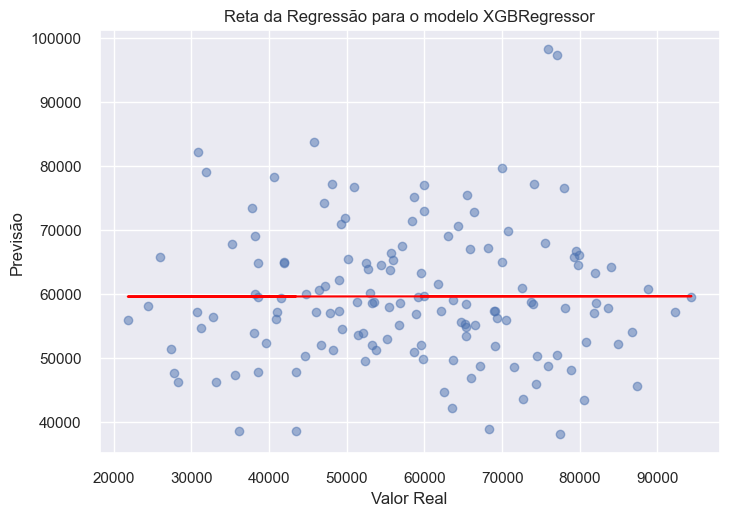

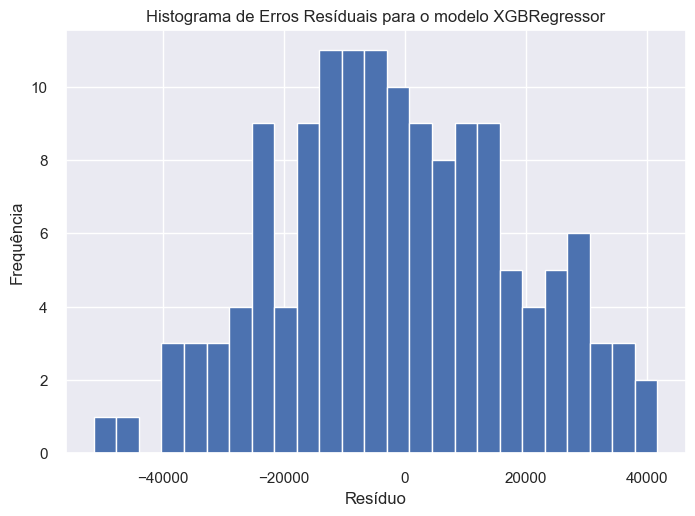

2023-04-17 22:06:35,930 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  XGBRegressor
R2 CV:   -0.31
RMSE CV: 19731.99
MAPE CV: 31.90%


2023-04-17 22:06:39,772 - Ciclo de vida dos modelos rastreado com sucesso!
2023-04-17 22:06:39,773 - Função train_validation_eval iniciada
2023-04-17 22:06:39,773 - Iniciando loop de validação cruzada
2023-04-17 22:06:39,776 - Treinando LGBMRegressor com parâmetros padrão, fold 1
2023-04-17 22:06:39,860 - Prevendo conjunto de validação com LGBMRegressor padrão, fold 1
2023-04-17 22:06:39,863 - Avaliando resultados nos dados de validação
2023-04-17 22:06:39,866 - Treinando LGBMRegressor com parâmetros padrão, fold 2
2023-04-17 22:06:39,955 - Prevendo conjunto de validação com LGBMRegressor padrão, fold 2
2023-04-17 22:06:39,960 - Avaliando resultados nos dados de validação
2023-04-17 22:06:39,965 - Treinando LGBMRegressor com parâmetros padrão, fold 3
2023-04-17 22:06:40,044 - Prevendo conjunto de validação com LGBMRegressor padrão, fold 3
2023-04-17 22:06:40,047 - Avaliando resultados nos dados de validação
2023-04-17 22:06:40,050 - Treinando LGBMRegressor com parâmetros padrão, fold 4

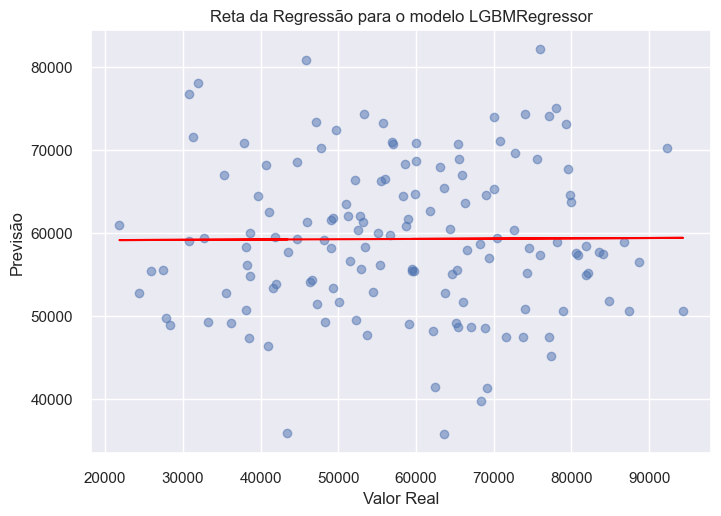

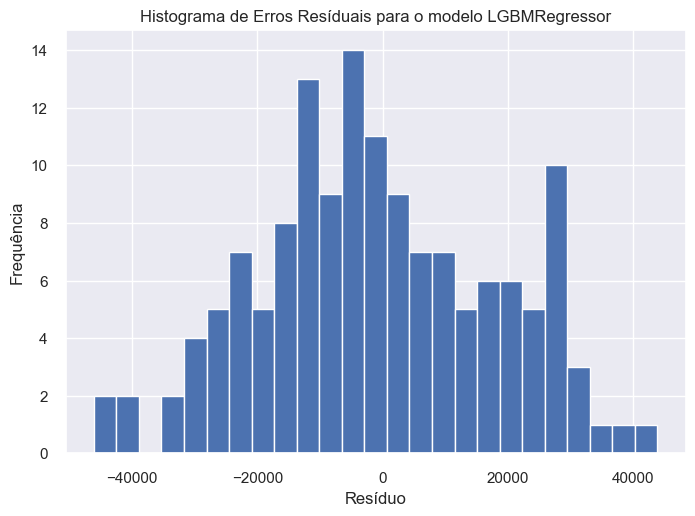

2023-04-17 22:06:41,504 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  LGBMRegressor
R2 CV:   -0.19
RMSE CV: 18866.82
MAPE CV: 30.67%


2023-04-17 22:06:45,547 - Ciclo de vida dos modelos rastreado com sucesso!
2023-04-17 22:06:45,548 - Função train_validation_eval iniciada
2023-04-17 22:06:45,548 - Iniciando loop de validação cruzada
2023-04-17 22:06:45,553 - Treinando CatBoostRegressor com parâmetros padrão, fold 1


Learning rate set to 0.037484
0:	learn: 17606.6235938	total: 147ms	remaining: 2m 27s
1:	learn: 17575.3313267	total: 149ms	remaining: 1m 14s
2:	learn: 17545.9476793	total: 151ms	remaining: 50s
3:	learn: 17518.5690416	total: 152ms	remaining: 37.8s
4:	learn: 17497.9672724	total: 153ms	remaining: 30.5s
5:	learn: 17472.3817266	total: 154ms	remaining: 25.6s
6:	learn: 17453.3220799	total: 156ms	remaining: 22.1s
7:	learn: 17431.3308801	total: 157ms	remaining: 19.4s
8:	learn: 17410.5849868	total: 158ms	remaining: 17.3s
9:	learn: 17393.4168213	total: 158ms	remaining: 15.7s
10:	learn: 17364.0951438	total: 159ms	remaining: 14.3s
11:	learn: 17331.2118400	total: 160ms	remaining: 13.2s
12:	learn: 17302.3218196	total: 161ms	remaining: 12.3s
13:	learn: 17279.3839094	total: 162ms	remaining: 11.4s
14:	learn: 17255.7188943	total: 163ms	remaining: 10.7s
15:	learn: 17243.6554023	total: 164ms	remaining: 10.1s
16:	learn: 17239.3542220	total: 165ms	remaining: 9.55s
17:	learn: 17213.2792332	total: 166ms	remaini

2023-04-17 22:06:46,908 - Prevendo conjunto de validação com CatBoostRegressor padrão, fold 1
2023-04-17 22:06:46,915 - Avaliando resultados nos dados de validação
2023-04-17 22:06:46,919 - Treinando CatBoostRegressor com parâmetros padrão, fold 2


965:	learn: 8611.1358213	total: 1.09s	remaining: 38.4ms
966:	learn: 8608.4540941	total: 1.09s	remaining: 37.3ms
967:	learn: 8605.2210415	total: 1.09s	remaining: 36.2ms
968:	learn: 8603.0764198	total: 1.09s	remaining: 35ms
969:	learn: 8599.0814026	total: 1.1s	remaining: 33.9ms
970:	learn: 8593.7832970	total: 1.1s	remaining: 32.8ms
971:	learn: 8592.1050960	total: 1.1s	remaining: 31.6ms
972:	learn: 8588.4038107	total: 1.1s	remaining: 30.5ms
973:	learn: 8581.1298562	total: 1.1s	remaining: 29.4ms
974:	learn: 8578.2290785	total: 1.1s	remaining: 28.2ms
975:	learn: 8570.9320528	total: 1.1s	remaining: 27.1ms
976:	learn: 8565.1175791	total: 1.1s	remaining: 26ms
977:	learn: 8562.3640427	total: 1.1s	remaining: 24.8ms
978:	learn: 8560.7740459	total: 1.1s	remaining: 23.7ms
979:	learn: 8555.3216151	total: 1.11s	remaining: 22.6ms
980:	learn: 8551.8929595	total: 1.11s	remaining: 21.4ms
981:	learn: 8547.4591792	total: 1.11s	remaining: 20.3ms
982:	learn: 8539.8933338	total: 1.11s	remaining: 19.2ms
983:	l

2023-04-17 22:06:48,095 - Prevendo conjunto de validação com CatBoostRegressor padrão, fold 2
2023-04-17 22:06:48,097 - Avaliando resultados nos dados de validação
2023-04-17 22:06:48,101 - Treinando CatBoostRegressor com parâmetros padrão, fold 3


988:	learn: 8686.3849860	total: 989ms	remaining: 11ms
989:	learn: 8684.3909152	total: 991ms	remaining: 10ms
990:	learn: 8676.5890344	total: 992ms	remaining: 9.01ms
991:	learn: 8666.7710371	total: 993ms	remaining: 8.01ms
992:	learn: 8666.0128168	total: 994ms	remaining: 7.01ms
993:	learn: 8661.8756275	total: 995ms	remaining: 6.01ms
994:	learn: 8656.7160105	total: 996ms	remaining: 5ms
995:	learn: 8652.8252173	total: 997ms	remaining: 4ms
996:	learn: 8647.4574010	total: 998ms	remaining: 3ms
997:	learn: 8642.1991519	total: 999ms	remaining: 2ms
998:	learn: 8642.0146120	total: 1000ms	remaining: 1ms
999:	learn: 8638.7550023	total: 1s	remaining: 0us
Learning rate set to 0.037495
0:	learn: 17140.1168256	total: 1.28ms	remaining: 1.28s
1:	learn: 17108.2921624	total: 2.3ms	remaining: 1.15s
2:	learn: 17088.8961987	total: 3.19ms	remaining: 1.06s
3:	learn: 17060.3810888	total: 4.08ms	remaining: 1.01s
4:	learn: 17027.6189243	total: 4.99ms	remaining: 994ms
5:	learn: 17004.6249605	total: 5.86ms	remaining:

2023-04-17 22:06:49,240 - Prevendo conjunto de validação com CatBoostRegressor padrão, fold 3
2023-04-17 22:06:49,244 - Avaliando resultados nos dados de validação
2023-04-17 22:06:49,247 - Treinando CatBoostRegressor com parâmetros padrão, fold 4


876:	learn: 8914.4918775	total: 849ms	remaining: 119ms
877:	learn: 8910.3879430	total: 850ms	remaining: 118ms
878:	learn: 8901.1413184	total: 851ms	remaining: 117ms
879:	learn: 8896.6643119	total: 852ms	remaining: 116ms
880:	learn: 8893.0376604	total: 853ms	remaining: 115ms
881:	learn: 8886.9302726	total: 854ms	remaining: 114ms
882:	learn: 8881.3551606	total: 855ms	remaining: 113ms
883:	learn: 8872.3798863	total: 856ms	remaining: 112ms
884:	learn: 8862.8552295	total: 857ms	remaining: 111ms
885:	learn: 8857.1653141	total: 858ms	remaining: 110ms
886:	learn: 8854.9740159	total: 859ms	remaining: 109ms
887:	learn: 8848.0868253	total: 860ms	remaining: 108ms
888:	learn: 8847.4183641	total: 861ms	remaining: 107ms
889:	learn: 8838.4078661	total: 862ms	remaining: 106ms
890:	learn: 8829.7627997	total: 863ms	remaining: 106ms
891:	learn: 8821.8093705	total: 864ms	remaining: 105ms
892:	learn: 8820.8711368	total: 865ms	remaining: 104ms
893:	learn: 8817.2685584	total: 866ms	remaining: 103ms
894:	learn

2023-04-17 22:06:50,391 - Prevendo conjunto de validação com CatBoostRegressor padrão, fold 4
2023-04-17 22:06:50,394 - Avaliando resultados nos dados de validação
2023-04-17 22:06:50,398 - Treinando CatBoostRegressor com parâmetros padrão, fold 5


943:	learn: 8725.1124580	total: 918ms	remaining: 54.5ms
944:	learn: 8720.6557879	total: 919ms	remaining: 53.5ms
945:	learn: 8710.3358682	total: 921ms	remaining: 52.5ms
946:	learn: 8703.5368036	total: 921ms	remaining: 51.6ms
947:	learn: 8701.8712160	total: 922ms	remaining: 50.6ms
948:	learn: 8692.7559968	total: 923ms	remaining: 49.6ms
949:	learn: 8683.1930044	total: 924ms	remaining: 48.7ms
950:	learn: 8680.5124000	total: 925ms	remaining: 47.7ms
951:	learn: 8677.1649302	total: 926ms	remaining: 46.7ms
952:	learn: 8666.5022181	total: 927ms	remaining: 45.7ms
953:	learn: 8660.2141398	total: 928ms	remaining: 44.8ms
954:	learn: 8659.6878364	total: 929ms	remaining: 43.8ms
955:	learn: 8657.0587409	total: 930ms	remaining: 42.8ms
956:	learn: 8652.4242957	total: 931ms	remaining: 41.8ms
957:	learn: 8645.8027700	total: 932ms	remaining: 40.9ms
958:	learn: 8639.4752508	total: 933ms	remaining: 39.9ms
959:	learn: 8635.4187686	total: 934ms	remaining: 38.9ms
960:	learn: 8625.2287283	total: 935ms	remaining:

2023-04-17 22:06:51,541 - Prevendo conjunto de validação com CatBoostRegressor padrão, fold 5
2023-04-17 22:06:51,547 - Avaliando resultados nos dados de validação
2023-04-17 22:06:51,547 - Treinando CatBoostRegressor com parâmetros padrão, fold 6


982:	learn: 8471.8834088	total: 960ms	remaining: 16.6ms
983:	learn: 8467.9292771	total: 961ms	remaining: 15.6ms
984:	learn: 8465.0419156	total: 962ms	remaining: 14.7ms
985:	learn: 8455.9914910	total: 963ms	remaining: 13.7ms
986:	learn: 8447.3996064	total: 964ms	remaining: 12.7ms
987:	learn: 8444.4708790	total: 965ms	remaining: 11.7ms
988:	learn: 8440.1810993	total: 966ms	remaining: 10.7ms
989:	learn: 8439.2822051	total: 967ms	remaining: 9.77ms
990:	learn: 8436.3345685	total: 968ms	remaining: 8.79ms
991:	learn: 8429.5466329	total: 969ms	remaining: 7.81ms
992:	learn: 8421.0298249	total: 970ms	remaining: 6.84ms
993:	learn: 8420.1444885	total: 971ms	remaining: 5.86ms
994:	learn: 8419.5447975	total: 972ms	remaining: 4.88ms
995:	learn: 8415.3681028	total: 973ms	remaining: 3.91ms
996:	learn: 8409.9209004	total: 974ms	remaining: 2.93ms
997:	learn: 8405.6082470	total: 975ms	remaining: 1.95ms
998:	learn: 8402.8973759	total: 976ms	remaining: 976us
999:	learn: 8397.3971864	total: 977ms	remaining: 

2023-04-17 22:06:52,742 - Prevendo conjunto de validação com CatBoostRegressor padrão, fold 6


861:	learn: 9250.0400128	total: 861ms	remaining: 138ms
862:	learn: 9243.9323741	total: 863ms	remaining: 137ms
863:	learn: 9237.1655913	total: 864ms	remaining: 136ms
864:	learn: 9230.6103930	total: 865ms	remaining: 135ms
865:	learn: 9226.6010878	total: 866ms	remaining: 134ms
866:	learn: 9215.9316589	total: 867ms	remaining: 133ms
867:	learn: 9213.0378702	total: 868ms	remaining: 132ms
868:	learn: 9205.6017769	total: 869ms	remaining: 131ms
869:	learn: 9199.5422692	total: 870ms	remaining: 130ms
870:	learn: 9195.5237756	total: 871ms	remaining: 129ms
871:	learn: 9195.1266867	total: 872ms	remaining: 128ms
872:	learn: 9193.1411754	total: 873ms	remaining: 127ms
873:	learn: 9187.6014100	total: 875ms	remaining: 126ms
874:	learn: 9187.2584478	total: 876ms	remaining: 125ms
875:	learn: 9182.2925625	total: 876ms	remaining: 124ms
876:	learn: 9181.9508310	total: 878ms	remaining: 123ms
877:	learn: 9179.3660717	total: 879ms	remaining: 122ms
878:	learn: 9174.5564303	total: 879ms	remaining: 121ms
879:	learn

2023-04-17 22:06:52,748 - Avaliando resultados nos dados de validação
2023-04-17 22:06:52,752 - Treinando CatBoostRegressor com parâmetros padrão, fold 7


Learning rate set to 0.037495
0:	learn: 17340.8111535	total: 2.08ms	remaining: 2.08s
1:	learn: 17321.2734567	total: 3.05ms	remaining: 1.52s
2:	learn: 17294.9631820	total: 4.1ms	remaining: 1.36s
3:	learn: 17263.5865153	total: 5.02ms	remaining: 1.25s
4:	learn: 17230.2295527	total: 5.93ms	remaining: 1.18s
5:	learn: 17204.0010995	total: 6.84ms	remaining: 1.13s
6:	learn: 17181.4377783	total: 7.99ms	remaining: 1.13s
7:	learn: 17151.6480245	total: 8.93ms	remaining: 1.11s
8:	learn: 17132.9254000	total: 9.86ms	remaining: 1.09s
9:	learn: 17112.2799574	total: 10.8ms	remaining: 1.07s
10:	learn: 17083.4046418	total: 11.7ms	remaining: 1.05s
11:	learn: 17058.3234053	total: 12.6ms	remaining: 1.03s
12:	learn: 17025.2891019	total: 13.5ms	remaining: 1.02s
13:	learn: 17003.2208797	total: 14.5ms	remaining: 1.02s
14:	learn: 16986.9793713	total: 15.6ms	remaining: 1.02s
15:	learn: 16973.1253902	total: 16.6ms	remaining: 1.02s
16:	learn: 16952.5858919	total: 17.6ms	remaining: 1.02s
17:	learn: 16935.9278711	tota

2023-04-17 22:06:53,911 - Prevendo conjunto de validação com CatBoostRegressor padrão, fold 7
2023-04-17 22:06:53,914 - Avaliando resultados nos dados de validação
2023-04-17 22:06:53,917 - Treinando CatBoostRegressor com parâmetros padrão, fold 8


905:	learn: 8923.8507021	total: 888ms	remaining: 92.1ms
906:	learn: 8919.1764829	total: 889ms	remaining: 91.1ms
907:	learn: 8909.9129596	total: 890ms	remaining: 90.2ms
908:	learn: 8903.1183283	total: 891ms	remaining: 89.2ms
909:	learn: 8897.8121696	total: 892ms	remaining: 88.2ms
910:	learn: 8895.7181730	total: 893ms	remaining: 87.3ms
911:	learn: 8887.6476416	total: 894ms	remaining: 86.3ms
912:	learn: 8879.1881222	total: 895ms	remaining: 85.3ms
913:	learn: 8878.2297719	total: 896ms	remaining: 84.3ms
914:	learn: 8875.5375196	total: 897ms	remaining: 83.3ms
915:	learn: 8869.1754341	total: 898ms	remaining: 82.4ms
916:	learn: 8866.3179064	total: 899ms	remaining: 81.4ms
917:	learn: 8863.8101827	total: 900ms	remaining: 80.4ms
918:	learn: 8853.7475697	total: 902ms	remaining: 79.5ms
919:	learn: 8850.0205001	total: 902ms	remaining: 78.5ms
920:	learn: 8846.0886467	total: 903ms	remaining: 77.5ms
921:	learn: 8841.2280541	total: 904ms	remaining: 76.5ms
922:	learn: 8839.2889906	total: 905ms	remaining:

2023-04-17 22:06:55,078 - Prevendo conjunto de validação com CatBoostRegressor padrão, fold 8
2023-04-17 22:06:55,078 - Avaliando resultados nos dados de validação
2023-04-17 22:06:55,078 - Treinando CatBoostRegressor com parâmetros padrão, fold 9


954:	learn: 8503.7709284	total: 950ms	remaining: 44.7ms
955:	learn: 8503.0527647	total: 951ms	remaining: 43.8ms
956:	learn: 8500.8420225	total: 952ms	remaining: 42.8ms
957:	learn: 8496.4289215	total: 953ms	remaining: 41.8ms
958:	learn: 8496.0853189	total: 954ms	remaining: 40.8ms
959:	learn: 8489.0086189	total: 955ms	remaining: 39.8ms
960:	learn: 8485.4142084	total: 956ms	remaining: 38.8ms
961:	learn: 8484.7590807	total: 957ms	remaining: 37.8ms
962:	learn: 8474.0239914	total: 958ms	remaining: 36.8ms
963:	learn: 8468.7837918	total: 959ms	remaining: 35.8ms
964:	learn: 8463.0742440	total: 961ms	remaining: 34.8ms
965:	learn: 8455.8958994	total: 962ms	remaining: 33.8ms
966:	learn: 8453.6589838	total: 963ms	remaining: 32.8ms
967:	learn: 8449.6319973	total: 964ms	remaining: 31.9ms
968:	learn: 8445.3014832	total: 964ms	remaining: 30.9ms
969:	learn: 8442.0981700	total: 965ms	remaining: 29.9ms
970:	learn: 8441.1909311	total: 966ms	remaining: 28.9ms
971:	learn: 8440.7030563	total: 967ms	remaining:

2023-04-17 22:06:56,269 - Prevendo conjunto de validação com CatBoostRegressor padrão, fold 9
2023-04-17 22:06:56,273 - Avaliando resultados nos dados de validação
2023-04-17 22:06:56,277 - Treinando CatBoostRegressor com parâmetros padrão, fold 10


992:	learn: 8870.5437201	total: 997ms	remaining: 7.03ms
993:	learn: 8863.8560169	total: 998ms	remaining: 6.03ms
994:	learn: 8855.7197493	total: 999ms	remaining: 5.02ms
995:	learn: 8855.1237159	total: 1s	remaining: 4.02ms
996:	learn: 8850.8627292	total: 1s	remaining: 3.01ms
997:	learn: 8845.4502047	total: 1s	remaining: 2.01ms
998:	learn: 8840.7729865	total: 1s	remaining: 1ms
999:	learn: 8834.9927804	total: 1s	remaining: 0us
Learning rate set to 0.037495
0:	learn: 17538.0212575	total: 1.9ms	remaining: 1.89s
1:	learn: 17507.3748770	total: 2.96ms	remaining: 1.48s
2:	learn: 17481.6204270	total: 3.98ms	remaining: 1.32s
3:	learn: 17447.0499385	total: 4.9ms	remaining: 1.22s
4:	learn: 17428.0431066	total: 5.82ms	remaining: 1.16s
5:	learn: 17398.4681159	total: 6.74ms	remaining: 1.12s
6:	learn: 17377.0449913	total: 7.61ms	remaining: 1.08s
7:	learn: 17351.5654466	total: 8.56ms	remaining: 1.06s
8:	learn: 17329.4020695	total: 9.5ms	remaining: 1.04s
9:	learn: 17308.4278708	total: 10.4ms	remaining: 1.

2023-04-17 22:06:57,474 - Prevendo conjunto de validação com CatBoostRegressor padrão, fold 10
2023-04-17 22:06:57,476 - Avaliando resultados nos dados de validação


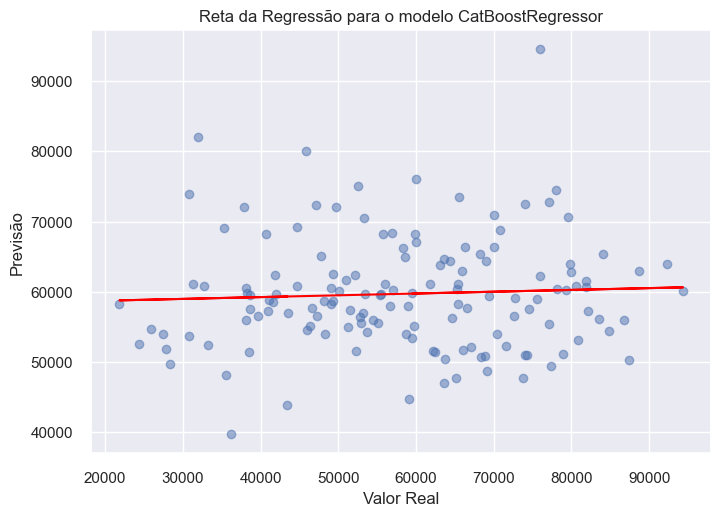

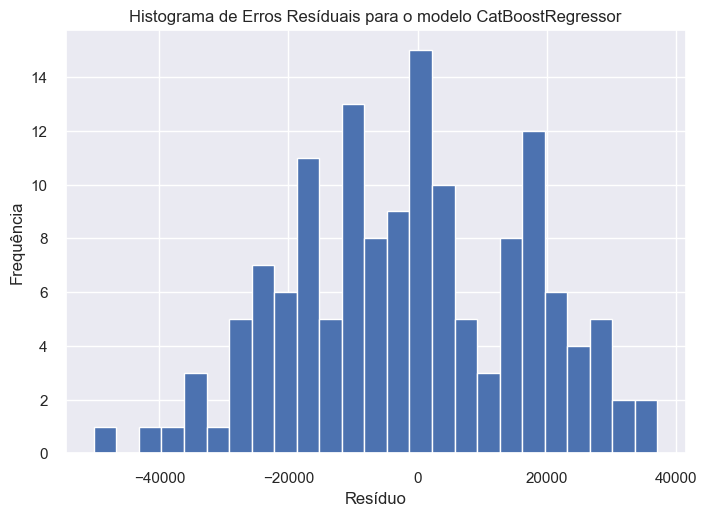

2023-04-17 22:06:58,200 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  CatBoostRegressor
R2 CV:   -0.12
RMSE CV: 18270.57
MAPE CV: 29.81%


2023-04-17 22:07:02,303 - Ciclo de vida dos modelos rastreado com sucesso!


In [66]:
# definir lista de algoritmos a serem testados
algoritmos = [
    ('LinearRegression', LinearRegression()),
    ('RandomForestRegressor', RandomForestRegressor()),
    ('Ridge', Ridge()),
    ('Lasso', Lasso()),
    ('ElasticNet', ElasticNet()),
    ('SVR', SVR()),
    ('MLPRegressor', MLPRegressor()),
    ('XGBRegressor', XGBRegressor()),
    ('LGBMRegressor', LGBMRegressor()),
    ('CatBoostRegressor', CatBoostRegressor())
]

experiment_name = 'Modelos com parâmetros padrão - treino e validação'

# Treinar e validar os vários algoritmos acima:
for model_name, model in algoritmos:
    
    # Executar função sem GridSearch
    date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
    model_name_date = model_name + ' - ' + date
    
    train_validation_eval(model_name=model_name, model=model, X=X, y=y, gridsearch=False, run_name=model_name_date, experiment_name=experiment_name, path_save_fig=path_save_fig)

### Resultados 

-  Avaliando os resultados no MLflow o modelo ElasticNet obteve o melhor resultado de RMSE dentre os algoritmos testados.
- Irei otimizar alguns modelos para finalizar o banchmark completo

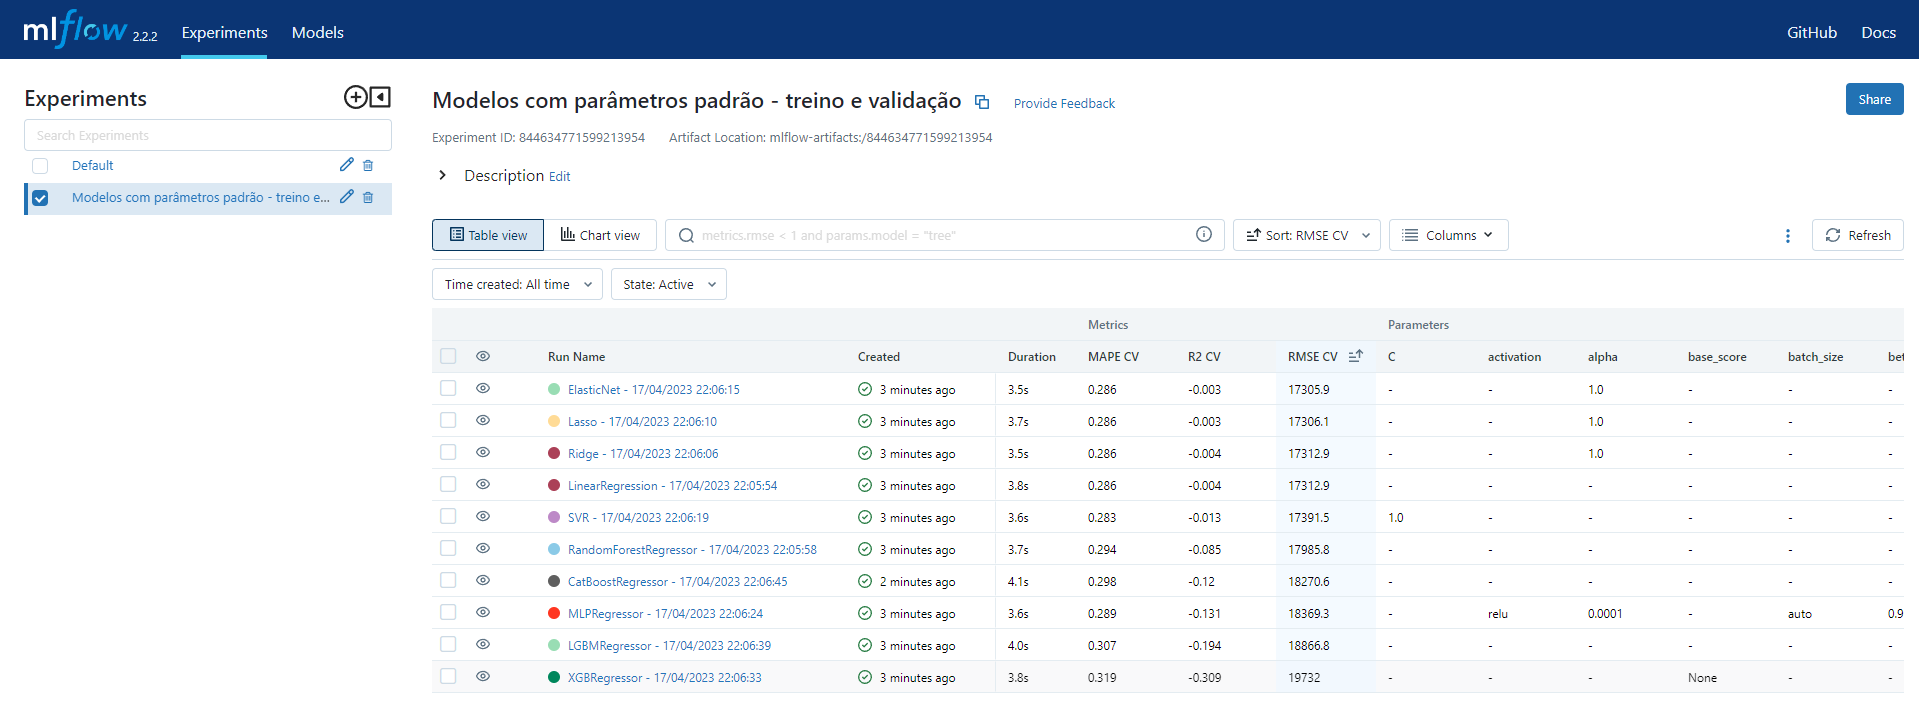

### GridSearch nos modelos que tendem a ter melhores resultados otimizados

#### ElasticNet

2023-04-17 22:13:37,360 - Função train_validation_eval iniciada
2023-04-17 22:13:37,362 - Iniciando loop de validação cruzada
2023-04-17 22:13:37,364 - Treinando ElasticNet com parâmetros otimizados pelo GridSearch, fold 1
2023-04-17 22:13:39,947 - Prevendo conjunto de validação com ElasticNet otimizado, fold 1
2023-04-17 22:13:39,949 - Avaliando resultados nos dados de validação
2023-04-17 22:13:39,953 - Treinando ElasticNet com parâmetros otimizados pelo GridSearch, fold 2
2023-04-17 22:13:41,993 - Prevendo conjunto de validação com ElasticNet otimizado, fold 2
2023-04-17 22:13:41,995 - Avaliando resultados nos dados de validação
2023-04-17 22:13:41,997 - Treinando ElasticNet com parâmetros otimizados pelo GridSearch, fold 3
2023-04-17 22:13:44,022 - Prevendo conjunto de validação com ElasticNet otimizado, fold 3
2023-04-17 22:13:44,024 - Avaliando resultados nos dados de validação
2023-04-17 22:13:44,027 - Treinando ElasticNet com parâmetros otimizados pelo GridSearch, fold 4
2023-0

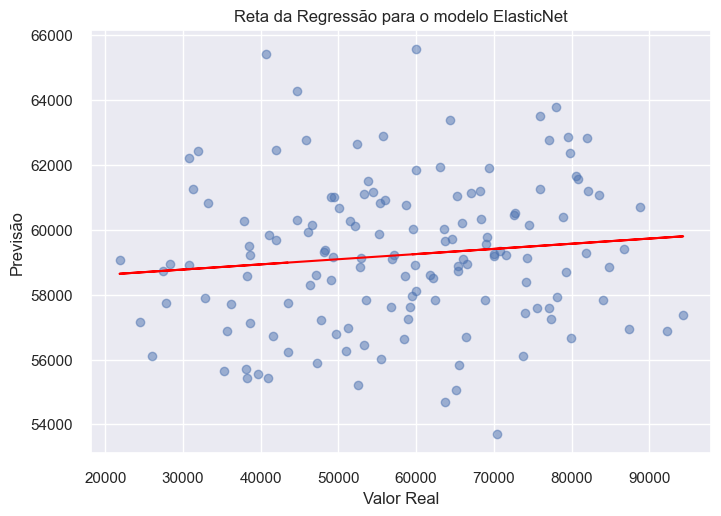

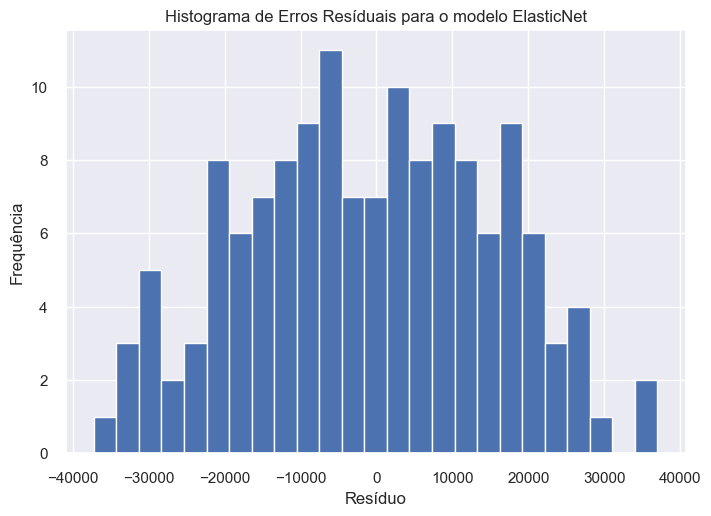

2023-04-17 22:14:01,128 - Rastreamento de resultados dos experimentos com MLFLOW iniciado
2023/04/17 22:14:01 INFO mlflow.tracking.fluent: Experiment with name 'Modelos com hiperparâmetros tunados - treino e validação' does not exist. Creating a new experiment.


Modelo:  ElasticNet
R2 CV:   0.00
RMSE CV: 17272.01
MAPE CV: 28.54%
Melhores parâmetros: {'alpha': 2.0, 'fit_intercept': True, 'l1_ratio': 0.1, 'max_iter': 100, 'tol': 0.001}
Melhor modelo: ElasticNet(alpha=2.0, l1_ratio=0.1, max_iter=100, tol=0.001)


2023-04-17 22:14:04,885 - Ciclo de vida dos modelos rastreado com sucesso!


In [74]:
# definir algoritmo a ser otimizado
Elastic = ElasticNet()

# define os hiperparâmetros a serem testados
params = {
    'alpha': [0.1, 0.5, 1.0, 2.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
    'max_iter': [100, 500, 1000],
    'tol': [1e-3, 1e-4, 1e-5],
    'fit_intercept': [True, False]
}

experiment_name = 'Modelos com hiperparâmetros tunados - treino e validação'

    
# Executar função com GridSearch
date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'ElasticNet'
model_name_date = model_name + ' - ' + date
    
train_validation_eval(model_name=model_name, model=Elastic, X=X, y=y, gridsearch=True, params_grid=params, run_name=model_name_date, experiment_name=experiment_name, path_save_fig=path_save_fig)

2023-04-17 22:14:04,907 - Função train_validation_eval iniciada
2023-04-17 22:14:04,907 - Iniciando loop de validação cruzada
2023-04-17 22:14:04,912 - Treinando Elastic_opt com parâmetros padrão, fold 1
2023-04-17 22:14:04,915 - Prevendo conjunto de validação com Elastic_opt padrão, fold 1
2023-04-17 22:14:04,917 - Avaliando resultados nos dados de validação
2023-04-17 22:14:04,921 - Treinando Elastic_opt com parâmetros padrão, fold 2
2023-04-17 22:14:04,924 - Prevendo conjunto de validação com Elastic_opt padrão, fold 2
2023-04-17 22:14:04,927 - Avaliando resultados nos dados de validação
2023-04-17 22:14:04,932 - Treinando Elastic_opt com parâmetros padrão, fold 3
2023-04-17 22:14:04,937 - Prevendo conjunto de validação com Elastic_opt padrão, fold 3
2023-04-17 22:14:04,939 - Avaliando resultados nos dados de validação
2023-04-17 22:14:04,943 - Treinando Elastic_opt com parâmetros padrão, fold 4
2023-04-17 22:14:04,946 - Prevendo conjunto de validação com Elastic_opt padrão, fold 4


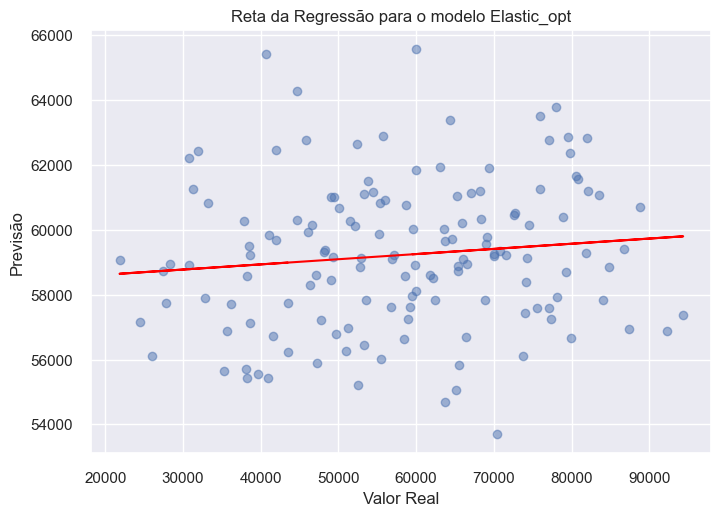

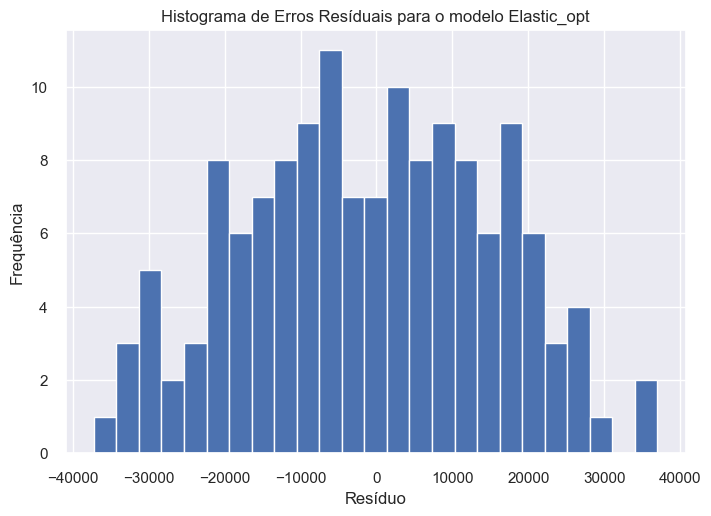

2023-04-17 22:14:05,799 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  Elastic_opt
R2 CV:   0.00
RMSE CV: 17272.01
MAPE CV: 28.54%


2023-04-17 22:14:09,586 - Ciclo de vida dos modelos rastreado com sucesso!


CPU times: total: 672 ms
Wall time: 4.68 s


In [75]:
%%time
# Retreinando modelo otimizado com novos hiperparâmetros
Elastic_opt = ElasticNet(alpha=2.0, l1_ratio=0.1, fit_intercept=True, max_iter=100, tol=0.001)

experiment_name = 'Modelos com hiperparâmetros tunados - treino e validação'

date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'Elastic_opt'
model_name_date = model_name + ' - ' + date

train_validation_eval(model_name=model_name, 
                      model=Elastic_opt, 
                      X=X, 
                      y=y, 
                      gridsearch=False, 
                      params_grid=None, 
                      run_name=model_name_date, 
                      experiment_name=experiment_name,
                      path_save_fig=path_save_fig)

- Não Houve uma melhora expressiva nos resultados mesmo com a otimização !

#### Lasso

2023-04-17 22:14:09,604 - Função train_validation_eval iniciada
2023-04-17 22:14:09,606 - Iniciando loop de validação cruzada
2023-04-17 22:14:09,609 - Treinando Lasso_opt com parâmetros otimizados pelo GridSearch, fold 1
2023-04-17 22:14:15,687 - Prevendo conjunto de validação com Lasso_opt otimizado, fold 1
2023-04-17 22:14:15,688 - Avaliando resultados nos dados de validação
2023-04-17 22:14:15,693 - Treinando Lasso_opt com parâmetros otimizados pelo GridSearch, fold 2
2023-04-17 22:14:21,620 - Prevendo conjunto de validação com Lasso_opt otimizado, fold 2
2023-04-17 22:14:21,632 - Avaliando resultados nos dados de validação
2023-04-17 22:14:21,639 - Treinando Lasso_opt com parâmetros otimizados pelo GridSearch, fold 3
2023-04-17 22:14:27,385 - Prevendo conjunto de validação com Lasso_opt otimizado, fold 3
2023-04-17 22:14:27,386 - Avaliando resultados nos dados de validação
2023-04-17 22:14:27,390 - Treinando Lasso_opt com parâmetros otimizados pelo GridSearch, fold 4
2023-04-17 22

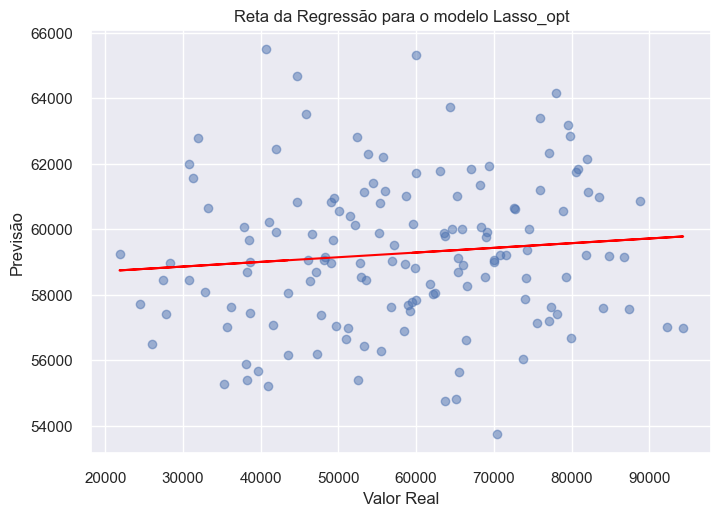

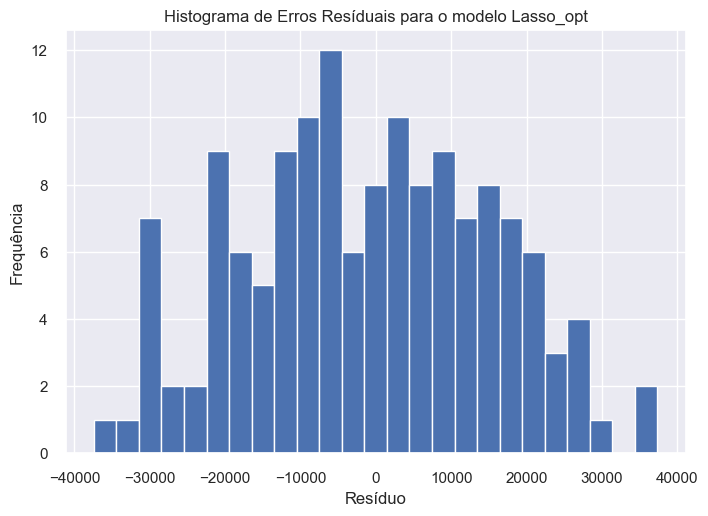

2023-04-17 22:15:06,517 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  Lasso_opt
R2 CV:   -0.00
RMSE CV: 17294.05
MAPE CV: 28.58%
Melhores parâmetros: {'alpha': 100, 'fit_intercept': True, 'max_iter': 1000, 'selection': 'random', 'tol': 1e-05}
Melhor modelo: Lasso(alpha=100, random_state=42, selection='random', tol=1e-05)


2023-04-17 22:15:10,991 - Ciclo de vida dos modelos rastreado com sucesso!


In [76]:
# definir algoritmo a ser otimizado
lasso_opt = Lasso(random_state=42)

# define os hiperparâmetros a serem testados
params = {
            'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
            'fit_intercept': [True, False],
            'max_iter': [1000, 5000, 10000],
            'selection':['cyclic', 'random'],
            'tol': [1e-3, 1e-4, 1e-5]
}

experiment_name = 'Modelos com hiperparâmetros tunados - treino e validação'

    
# Executar função com GridSearch
date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'Lasso_opt'
model_name_date = model_name + ' - ' + date
    
train_validation_eval(model_name=model_name, model=lasso_opt, X=X, y=y, gridsearch=True, params_grid=params, run_name=model_name_date, experiment_name=experiment_name, path_save_fig=path_save_fig)

2023-04-17 22:15:11,009 - Função train_validation_eval iniciada
2023-04-17 22:15:11,010 - Iniciando loop de validação cruzada
2023-04-17 22:15:11,014 - Treinando Lasso_opt com parâmetros padrão, fold 1
2023-04-17 22:15:11,019 - Prevendo conjunto de validação com Lasso_opt padrão, fold 1
2023-04-17 22:15:11,021 - Avaliando resultados nos dados de validação
2023-04-17 22:15:11,025 - Treinando Lasso_opt com parâmetros padrão, fold 2
2023-04-17 22:15:11,030 - Prevendo conjunto de validação com Lasso_opt padrão, fold 2
2023-04-17 22:15:11,032 - Avaliando resultados nos dados de validação
2023-04-17 22:15:11,034 - Treinando Lasso_opt com parâmetros padrão, fold 3
2023-04-17 22:15:11,038 - Prevendo conjunto de validação com Lasso_opt padrão, fold 3
2023-04-17 22:15:11,040 - Avaliando resultados nos dados de validação
2023-04-17 22:15:11,044 - Treinando Lasso_opt com parâmetros padrão, fold 4
2023-04-17 22:15:11,048 - Prevendo conjunto de validação com Lasso_opt padrão, fold 4
2023-04-17 22:15

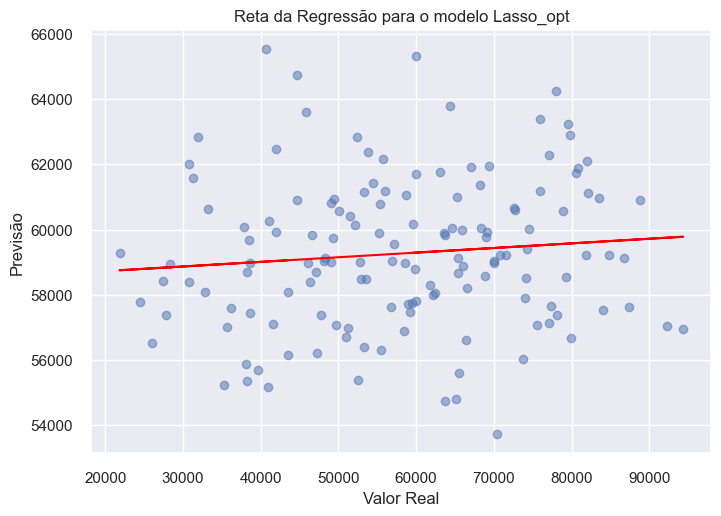

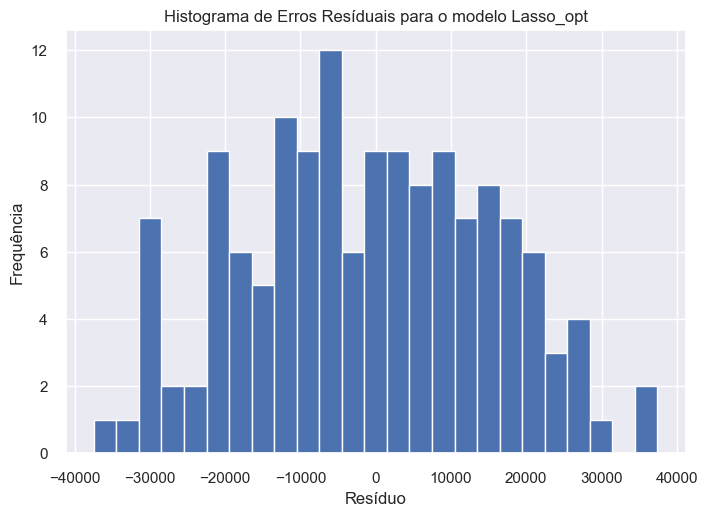

2023-04-17 22:15:11,924 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  Lasso_opt
R2 CV:   -0.00
RMSE CV: 17293.40
MAPE CV: 28.57%


2023-04-17 22:15:15,416 - Ciclo de vida dos modelos rastreado com sucesso!


In [77]:
# Retreinando modelo otimizado com novos hiperparâmetros
lasso_opt = Lasso(**{'alpha': 100, 'fit_intercept': True, 'max_iter': 1000, 'selection': 'random', 'tol': 1e-05})

experiment_name = 'Modelos com hiperparâmetros tunados - treino e validação'

date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'Lasso_opt'
model_name_date = model_name + ' - ' + date

train_validation_eval(model_name=model_name, 
                      model=lasso_opt, 
                      X=X, 
                      y=y, 
                      gridsearch=False, 
                      params_grid=None, 
                      run_name=model_name_date, 
                      experiment_name=experiment_name,
                      path_save_fig=path_save_fig)

#### LinearRegression

2023-04-17 22:15:15,428 - Função train_validation_eval iniciada
2023-04-17 22:15:15,430 - Iniciando loop de validação cruzada
2023-04-17 22:15:15,433 - Treinando LinearRegression_opt com parâmetros otimizados pelo GridSearch, fold 1
2023-04-17 22:15:15,506 - Prevendo conjunto de validação com LinearRegression_opt otimizado, fold 1
2023-04-17 22:15:15,508 - Avaliando resultados nos dados de validação
2023-04-17 22:15:15,512 - Treinando LinearRegression_opt com parâmetros otimizados pelo GridSearch, fold 2
2023-04-17 22:15:15,595 - Prevendo conjunto de validação com LinearRegression_opt otimizado, fold 2
2023-04-17 22:15:15,598 - Avaliando resultados nos dados de validação
2023-04-17 22:15:15,602 - Treinando LinearRegression_opt com parâmetros otimizados pelo GridSearch, fold 3
2023-04-17 22:15:15,678 - Prevendo conjunto de validação com LinearRegression_opt otimizado, fold 3
2023-04-17 22:15:15,679 - Avaliando resultados nos dados de validação
2023-04-17 22:15:15,683 - Treinando LinearR

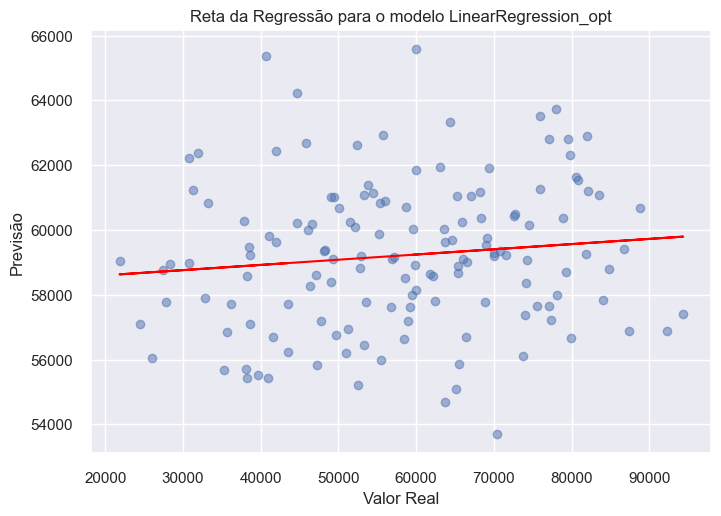

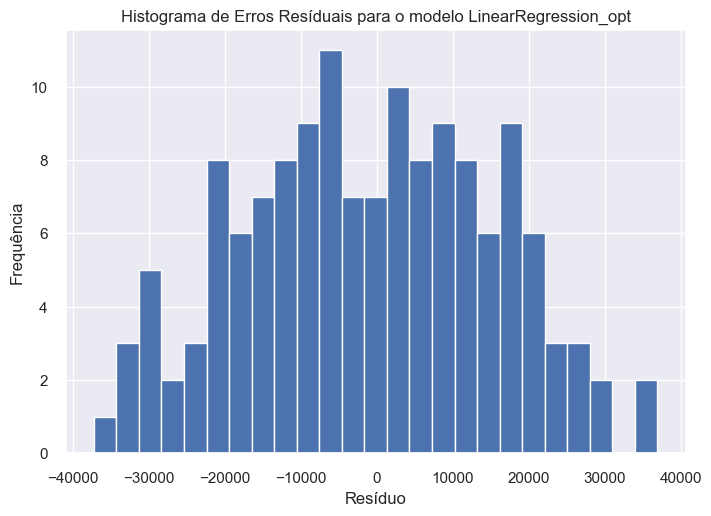

2023-04-17 22:15:16,991 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  LinearRegression_opt
R2 CV:   0.00
RMSE CV: 17258.37
MAPE CV: 28.52%
Melhores parâmetros: {'fit_intercept': True, 'positive': True}
Melhor modelo: LinearRegression(n_jobs=-1, positive=True)


2023-04-17 22:15:20,636 - Ciclo de vida dos modelos rastreado com sucesso!


In [78]:
# definir algoritmo a ser otimizado
linear_regression_opt = LinearRegression(n_jobs=-1)

# define os hiperparâmetros a serem testados
params = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

experiment_name = 'Modelos com hiperparâmetros tunados - treino e validação'

    
# Executar função com GridSearch
date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'LinearRegression_opt'
model_name_date = model_name + ' - ' + date
    
train_validation_eval(model_name=model_name, model=linear_regression_opt, X=X, y=y, gridsearch=True, params_grid=params, run_name=model_name_date, experiment_name=experiment_name, path_save_fig=path_save_fig)

2023-04-17 22:15:20,659 - Função train_validation_eval iniciada
2023-04-17 22:15:20,660 - Iniciando loop de validação cruzada
2023-04-17 22:15:20,663 - Treinando LinearRegression_opt com parâmetros padrão, fold 1
2023-04-17 22:15:20,666 - Prevendo conjunto de validação com LinearRegression_opt padrão, fold 1
2023-04-17 22:15:20,669 - Avaliando resultados nos dados de validação
2023-04-17 22:15:20,674 - Treinando LinearRegression_opt com parâmetros padrão, fold 2
2023-04-17 22:15:20,678 - Prevendo conjunto de validação com LinearRegression_opt padrão, fold 2
2023-04-17 22:15:20,679 - Avaliando resultados nos dados de validação
2023-04-17 22:15:20,683 - Treinando LinearRegression_opt com parâmetros padrão, fold 3
2023-04-17 22:15:20,686 - Prevendo conjunto de validação com LinearRegression_opt padrão, fold 3
2023-04-17 22:15:20,688 - Avaliando resultados nos dados de validação
2023-04-17 22:15:20,691 - Treinando LinearRegression_opt com parâmetros padrão, fold 4
2023-04-17 22:15:20,694 -

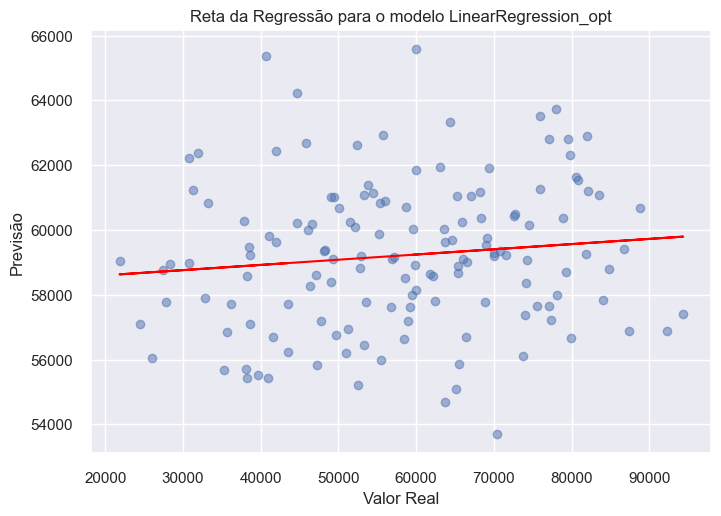

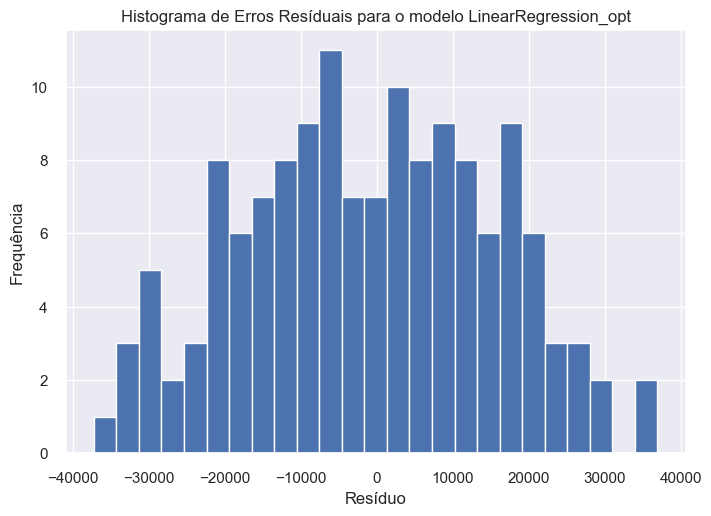

2023-04-17 22:15:21,601 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  LinearRegression_opt
R2 CV:   0.00
RMSE CV: 17258.37
MAPE CV: 28.52%


2023-04-17 22:15:25,124 - Ciclo de vida dos modelos rastreado com sucesso!


In [79]:
# Retreinando modelo otimizado com novos hiperparâmetros
linear_regression_opt = LinearRegression(**{'fit_intercept': True, 'positive': True})

experiment_name = 'Modelos com hiperparâmetros tunados - treino e validação'

date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'LinearRegression_opt'
model_name_date = model_name + ' - ' + date

train_validation_eval(model_name=model_name, 
                      model=linear_regression_opt, 
                      X=X, 
                      y=y, 
                      gridsearch=False, 
                      params_grid=None, 
                      run_name=model_name_date, 
                      experiment_name=experiment_name,
                      path_save_fig=path_save_fig)

#### RandomForestRegressor

2023-04-17 22:15:25,137 - Função train_validation_eval iniciada
2023-04-17 22:15:25,139 - Iniciando loop de validação cruzada
2023-04-17 22:15:25,143 - Treinando RandomForestRegressor_opt com parâmetros padrão, fold 1
2023-04-17 22:15:25,376 - Prevendo conjunto de validação com RandomForestRegressor_opt padrão, fold 1
2023-04-17 22:15:25,391 - Avaliando resultados nos dados de validação
2023-04-17 22:15:25,394 - Treinando RandomForestRegressor_opt com parâmetros padrão, fold 2
2023-04-17 22:15:25,624 - Prevendo conjunto de validação com RandomForestRegressor_opt padrão, fold 2
2023-04-17 22:15:25,639 - Avaliando resultados nos dados de validação
2023-04-17 22:15:25,642 - Treinando RandomForestRegressor_opt com parâmetros padrão, fold 3
2023-04-17 22:15:25,897 - Prevendo conjunto de validação com RandomForestRegressor_opt padrão, fold 3
2023-04-17 22:15:25,911 - Avaliando resultados nos dados de validação
2023-04-17 22:15:25,915 - Treinando RandomForestRegressor_opt com parâmetros padrã

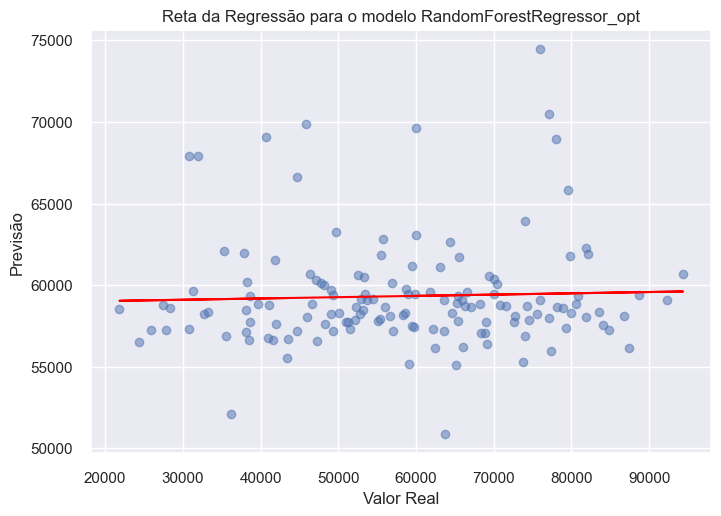

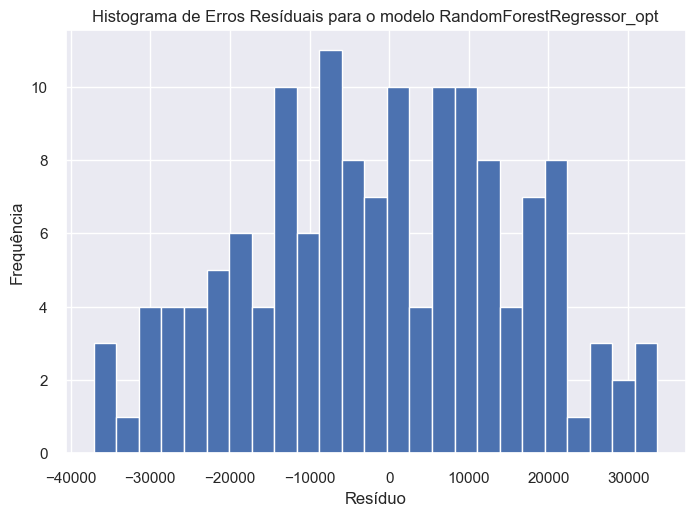

2023-04-17 22:15:28,394 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  RandomForestRegressor_opt
R2 CV:   -0.01
RMSE CV: 17330.37
MAPE CV: 28.67%


2023-04-17 22:15:31,842 - Ciclo de vida dos modelos rastreado com sucesso!


In [80]:
# modelo otimizado com novos hiperparâmetros
rfr_opt = RandomForestRegressor(bootstrap=True, max_depth=5, max_features='sqrt', n_estimators=200, random_state=42, min_samples_leaf=1, min_samples_split=2)

experiment_name = 'Modelos com hiperparâmetros tunados - treino e validação'

date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'RandomForestRegressor_opt'
model_name_date = model_name + ' - ' + date

train_validation_eval(model_name=model_name, 
                      model=rfr_opt, 
                      X=X, 
                      y=y, 
                      gridsearch=False, 
                      params_grid=None, 
                      run_name=model_name_date, 
                      experiment_name=experiment_name,
                      path_save_fig=path_save_fig)

#### XGBOOST

#### LIGHTGBM

#### CATBOOST

### Modelos otimizados ranking:

 -  A Regressão Linear se mostrou melhor na validação

## Teste

In [ ]:
# Separar variáveis independentes e dependente
X_test = df_teste.drop(['Store_Sales'], axis=1)
y_test = df_teste['Store_Sales']

In [ ]:
X_test.head()

In [ ]:
y_test

In [ ]:
# definir função de avaliação para conjunto de teste
def test_eval(model_name, model, X_test, y_test, run_name=None, experiment_name=None, path_save_fig=None):
    
    logging.info("Prevendo conjunto de teste com modelo treinado")
    # Usar modelo treinado para previsão no conjunto de teste
    yhat = model.predict(X_test)
    
    logging.info("Avaliando resultados nos dados de teste")
    #Avaliação
    # R2
    R2 = r2_score(y_test, yhat)
    # RMSE
    RMSE = np.sqrt(mean_squared_error(y_test, yhat))
    # MAPE
    MAPE = mean_absolute_percentage_error(y_test, yhat)
    
    # Erro de previsão com a reta da regressão
    p = np.polyfit(y_test, yhat, 1)
    plt.scatter(y_test, yhat, alpha=0.5)
    plt.plot(y_test, np.polyval(p, y_test), color='red')
    plt.xlabel('Valor Real')
    plt.ylabel('Previsão')
    plt.title(f'Reta da Regressão para o modelo {model_name}')
    plt.savefig(os.path.join(path_save_fig,f"{model_name}_regression_error.jpg"),bbox_inches='tight',transparent=False, format='JPG', facecolor='w') 
    plt.show()
    
    # Resíduos dos erros
    residuals = y_test - yhat
    plt.hist(residuals, bins=25)
    plt.xlabel('Resíduo')
    plt.ylabel('Frequência')
    plt.title(f'Histograma de Erros Resíduais para o modelo {model_name}')
    plt.savefig(os.path.join(path_save_fig,f"{model_name}_residuals.jpg"),bbox_inches='tight',transparent=False, format='JPG', facecolor='w') 
    plt.show()
   
        
    # Avaliação na validação
    print(f"Modelo: {model_name}")
    print(f"R2:     {R2:.2f}")
    print(f"RMSE:   {RMSE:.2f}")
    print(f"MAPE:   {MAPE:.2%}")
    
    logging.info("Rastreamento de resultados dos experimentos com MLFLOW iniciado")
    
    mlflow.set_experiment(experiment_name)
    mlflow.set_tracking_uri('http://127.0.0.1:5000')
    
    with mlflow.start_run(run_name=run_name):
        mlflow.log_metric('R2', R2)
        mlflow.log_metric('RMSE', RMSE)
        mlflow.log_metric('MAPE', MAPE)
        mlflow.log_artifact(os.path.join(path_save_fig,f"{model_name}_residuals.jpg"))
        mlflow.log_artifact(os.path.join(path_save_fig,f"{model_name}_regression_error.jpg"))
        mlflow.sklearn.log_model(model, model_name)
    mlflow.end_run()
        
    return logging.info('Ciclo de vida do modelo rastreado com sucesso!')
    

### ElasticNet otimizado

In [ ]:
# Melhor modelo apresentado do Sklearn

experiment_name = 'Melhor modelo apresentado do Sklearn - teste'

date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'Elastic_opt'
model_name_date = model_name + ' - ' + date


test_eval(model_name=model_name, model=Elastic_opt, X_test=X_test, y_test=y_test, run_name=model_name_date, experiment_name=experiment_name, path_save_fig=path_save_fig)

### Lasso otimizado

In [ ]:
experiment_name = 'Melhor modelo apresentado do Sklearn - teste'

date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'Lasso_opt'
model_name_date = model_name + ' - ' + date


test_eval(model_name=model_name, model=lasso_opt, X_test=X_test, y_test=y_test, run_name=model_name_date, experiment_name=experiment_name, path_save_fig=path_save_fig)

### RandomForestRegressor otimizado

In [ ]:
experiment_name = 'Melhor modelo apresentado do Sklearn - teste'

date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'RandomForestRegressor_opt'
model_name_date = model_name + ' - ' + date


test_eval(model_name=model_name, model=rfr_opt, X_test=X_test, y_test=y_test, run_name=model_name_date, experiment_name=experiment_name, path_save_fig=path_save_fig)

### Resultados no teste

- Surpreendentemente a RandomForest obteve melhor resultado no teste mesmo não performando bem na validação

- Próximos passos :
    - Criar novas features
    - Escalonar features
    - Transformar target com escala logarítmica

# Avaliação / ROI

# Deploy